# Summary


Dataset name  | Language | Number of samples
-------------------|--------------|----
News Category Dataset       | en | 209527
BBC news       | en | 2225
Panorama      | ru | 13744

# Utils

In [1]:
!pip install mdutils

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mdutils: filename=mdutils-1.6.0-py3-none-any.whl size=20726 sha256=ed028ba4604e8b45a253ed3f7ca4a8e62fc700791255e32ccb208646b65b7e80
  Stored in directory: /root/.cache/pip/wheels/fc/06/00/0b1f3d0bec86776c2330c61c21a57e8f65798df995ac1591ca
Successfully built mdutils


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import os
import csv
from mdutils.mdutils import MdUtils

## data cleaning


In [3]:
contractions_dict = {
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he's": "he is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "mustn't": "must not",
    "shan't": "shall not",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they're": "they are",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where's": "where is",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

In [4]:
def all_nonletters_substrings(df):
    all_words = []
    pattern = r"[^\w\d\.\,'\(\)\-?!:;’‘\"]"
    for text in df['headline']:
        text = text.lower()
        l = text.split()
        l = [
            word for word in l if re.search(pattern, word)
        ]
        all_words += l
    return all_words

In [5]:
def process_headline(text):
    try:
        text = text.encode('utf-8').decode('utf-8')
    except UnicodeDecodeError:
        print(text)
        text = ' '.join(char for char in text if ord(char) < 128)
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    text = text.lower()
    text = re.sub('&', ' and ', text)
    text = pattern.sub(lambda x: contractions_dict[x.group()], text)
    text = re.sub('[^a-z A-Z 0-9-]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [6]:
def process_categories_names(text):
    text = text.lower()
    text = re.sub(r'&', ' and ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [29]:
def dataset_analysis(data, filename, dataset_name, description, original_link, preprocessed_link):
    # generates .md file with basic info
    mdFile = MdUtils(file_name=f'{dataset_name}_info',title=f'{dataset_name}')
    mdFile.new_line(description)
    mdFile.new_line("After preprocess we get:")
    file_stats = os.stat(filename)
    items = [
        f'Dataset size: {"%.2f" % (file_stats.st_size / (1024 * 1024))} MB',
        f'{len(data)} samples'
    ]
    mdFile.new_list(items)
    mdFile.new_line('Original dataset: ' + mdFile.new_inline_link(link=original_link))
    mdFile.new_line('Preprocessed version: ' + mdFile.new_inline_link(link=preprocessed_link))

    mdFile.create_md_file()

## plots

In [8]:
def missing_data(data):
    print(data.info())
    val = data.isnull().sum()/data.shape[0] * 100.00
    if sum(val) == 0:
        print("No Missing Data")
    else:
        val = val[val > 0]
        val = pd.data({'Feature': val.index,
                        'Percent_Missing': val.values})
        val.sort_values('Percent_Missing', inplace=True)
        display(val)

    data['headline_len_symbols'] = [len(s) for s in data['headline']]
    data['headline_len_words'] = data['headline'].apply(lambda x: len(str(x).split()))

    print(f"Number of empty headlines: {len(data[data['headline_len_symbols'] == 0])}")
    data = data[data['headline_len_symbols'] != 0]
    print(f"New data len: {len(data)}")
    return data

In [9]:
def duplicates_info(data):
    duplicates_headline = data[data.duplicated(['headline'])]
    duplicates_headline_and_category = data[data.duplicated(['headline', 'category'])]
    print(f"number of duplicated headline: {len(duplicates_headline)}")
    print(f"number of duplicated headline&category: {len(duplicates_headline_and_category)}")
    # duplicated headlines with multiple categories
    df = data
    filtered_df = df.groupby('headline').filter(lambda x: x['category'].nunique() > 1)
    titles_with_different_categories = filtered_df.groupby('headline')['category'].unique()
    print(titles_with_different_categories)

In [10]:
def categories_distrib(data):
    print(f'number of categories: {len(data.category.unique())}')
    print(f'categories:\n{data.category.unique()}')
    print(data['category'].value_counts())
    # bar chart of categories of news articles
    data['category'].value_counts().plot.bar(figsize=(20, 10))
    # pie chart of top 20 categories of news articles
    category_value_counts = data['category'].value_counts()
    top20_list = sorted(list(zip(category_value_counts.values, category_value_counts.index)))[::-1]

    value_counts, class_names = zip(*top20_list)

    fig = plt.figure(figsize=(12,12))
    a = plt.pie(
        value_counts[:20],
        labels=class_names[:20],
        autopct='%1.1f%%',
        startangle=90,
        labeldistance=1.1,
        pctdistance=1.05,
        rotatelabels=45
    )

    plt.title(f'top {min(20, len(class_names))} categories')
    plt.show()

In [11]:
def min_max_len_symbols(data):
    fig = plt.figure(figsize=(20,10))
    a = plt.hist(
        data['headline_len_symbols'],
        50
    )
    plt.yscale('log')
    plt.xlabel('headline len in symbols')
    plt.ylabel('log of number of headlines')
    plt.show()

    min_len_symb = data.groupby('category')['headline_len_symbols'].min().sort_values(ascending=False).reset_index()
    max_len_symb = data.groupby('category')['headline_len_symbols'].max().sort_values(ascending=False).reset_index()

    len_symb = pd.merge(max_len_symb, min_len_symb, on='category', suffixes=('_max', '_min'))
    print(len_symb)
    plt.figure(figsize=(20,6))

    plt.subplot(121)
    plt.bar(max_len_symb['category'][:10], max_len_symb['headline_len_symbols'][:10])
    plt.xticks(rotation=45)
    plt.ylabel("Words length in news categories", size=14)
    plt.xlabel("News categories",  size=14)
    plt.title("Max length top 10 news categories", size=14)

    plt.subplot(122)
    plt.bar(min_len_symb['category'][-10:], min_len_symb['headline_len_symbols'][-10:])
    plt.xticks(rotation=45)
    plt.xlabel("News categories", size=14)
    plt.title("Min length of top 10 news categories", size=14)

    plt.show()

In [12]:
def min_max_len_words(data):
    fig = plt.figure(figsize=(20,10))
    a = plt.hist(
        data['headline_len_words'],
        50
    )
    plt.yscale('log')
    plt.xlabel('headline len in words')
    plt.ylabel('log of number of headlines')
    plt.show()

    min_len_words = data.groupby('category')['headline_len_words'].min().sort_values(ascending=False).reset_index()
    max_len_words = data.groupby('category')['headline_len_words'].max().sort_values(ascending=False).reset_index()

    len_words = pd.merge(max_len_words, min_len_words, on='category', suffixes=('_max', '_min'))

    print(len_words)

    plt.figure(figsize=(20,6))

    plt.subplot(121)
    plt.bar(max_len_words['category'][:10], max_len_words['headline_len_words'][:10])
    plt.xticks(rotation=45)
    plt.ylabel("Words length in news categories", size=14)
    plt.xlabel("News categories",  size=14)
    plt.title("Max length top 10 news categories", size=14)

    plt.subplot(122)
    plt.bar(min_len_words['category'][-10:], min_len_words['headline_len_words'][-10:])
    plt.xticks(rotation=45)
    plt.xlabel("News categories", size=14)
    plt.title("Min length of top 10 news categories", size=14)

    plt.show()

In [13]:
def word_clouds_top10(data):
    category_value_counts = data['category'].value_counts()
    top10_list = sorted(list(zip(category_value_counts.values, category_value_counts.index)))[::-1]

    value_counts, class_names = zip(*top10_list)

    top10categories = class_names[:10]

    articles_list = []
    for i in top10categories:
        cat_ndf = data[data['category'] == i]
        cat_array = cat_ndf['headline']
        articles_list.append(cat_array)

    wc1 = WordCloud(
        max_words=1000,
        min_font_size=10,
        height=600,
        width=1600,
        background_color='black',
        contour_color='black',
        colormap='plasma',
        repeat=True,
        stopwords=STOPWORDS
    )

    plt.figure(figsize=(15,15))

    for idx, j in enumerate(top10categories):
        plt.subplot(5,2,idx+1)
        cloud = wc1.generate(' '.join(articles_list[idx]))
        plt.imshow(cloud, interpolation= "bilinear")
        plt.title(f"Wordcloud for news topic {j}")
        plt.axis('off')

# News Category Dataset

https://www.kaggle.com/datasets/rmisra/news-category-dataset/data

## data preparation

In [41]:
!sudo unzip NewsCategoryDataset.zip

Archive:  NewsCategoryDataset.zip
replace News_Category_Dataset_v3.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: News_Category_Dataset_v3.json  


In [42]:
data = pd.read_json('News_Category_Dataset_v3.json', lines=True)

In [43]:
data.sample(3)

link  \
124456  https://www.huffingtonpost.com/entry/best-twee...   
152381  https://www.huffingtonpost.com/entry/sleeping-...   
109257  https://www.huffingtonpost.com/entry/how-can-b...   

                                        headline  category  \
124456  The Funniest Tweets From Women This Week     WOMEN   
152381           Sleeping in a Nicaraguan Canyon    TRAVEL   
109257           How Can Businesses Build Trust?  BUSINESS   

                                        short_description  \
124456                                                      
152381  I'd bought a plane ticket and it had taken me ...   
109257  Putting in place a new settlement on trust wil...   

                                                  authors       date  
124456                                    Alanna Vagianos 2014-08-02  
152381  Rosa Lia June, Contributor\nBlogger, Palestine... 2013-09-30  
109257  Cynthia Hansen, ContributorDirector, Head of P... 2015-01-24

In [44]:
data = data[['headline', 'category']]
data.sample(3)

headline  category
59732   LA Sheriff's Department Admits Deputy Killed A...  POLITICS
10025   Protestors Want Green Day's 'American Idiot' T...  POLITICS
139064                                       Silly Emails    TRAVEL

In [45]:
data_ = data
data_['headline'] = data_['headline'].apply(process_headline)
category_mapping = {
    "QUEER VOICES": "GROUPS VOICES",
    "BLACK VOICES": "GROUPS VOICES",
    "LATINO VOICES": "GROUPS VOICES",
    "ARTS": "ARTS & CULTURE",
    "CULTURE & ARTS": "ARTS & CULTURE",
    "BUSINESS": "BUSINESS & FINANCES",
    "MONEY": "BUSINESS & FINANCES",
    "SCIENCE": "SCIENCE & TECH",
    "TECH": "SCIENCE & TECH",
    "COLLEGE": "EDUCATION",
    "STYLE": "STYLE & BEAUTY",
    "HEALTHY LIVING": "WELLNESS",
    "PARENTS": "PARENTING",
    "GREEN": "ENVIRONMENT",
    "TASTE": "FOOD & DRINK",
    "WORLDPOST": "WORLD NEWS",
    "THE WORLDPOST": "WORLD NEWS",
    "FIFTY": "MISCELLANEOUS",
    "GOOD NEWS": "MISCELLANEOUS"
}
data_['category'] = data_['category'].replace(category_mapping)
data_['category'] = data_['category'].apply(process_categories_names)
data_.sample(3)

headline          category
23658          makeup hacks and tips everyone should know  style and beauty
2850    are at-home led skin care tools worth it and d...  style and beauty
181693  documentaries on the case the central park fiv...     entertainment

In [46]:
print(list(set(all_nonletters_substrings(data))))

[]


In [47]:
data_.to_csv('NewsCategoryDataset.csv', sep='\t')

In [48]:
dataset_analysis(
    data,
    'NewsCategoryDataset.csv',
    'News Category Dataset',
    'News headlines from 2012 to 2022 from HuffPost',
    'https://www.kaggle.com/datasets/rmisra/news-category-dataset',
    'https://www.dropbox.com/scl/fi/60p2dld5qcrycvymcwhca/NewsCategoryDataset.csv?rlkey=dyvw7v5o97gxqprfphd0sjp1f&dl=0.csv'
)

**Artifacts:**


1.   hashtags, tags ('#takeaknee?', '@openforum')
2.   swear words with the replacement of part of the letters (f@#%' 'f*ck')
3.   dates ('4/18/12', '1960′s')
4.   %
5.   \$, £, $220k
6.   \u200b
7.   links ('http://www.eurweb.com/2015/07/wggendy-williams-announces-12-city-sit-down-tour/#czdwtvg7bx2zhimt.99ams-announces-12-city-sit-down-tour/#czdwtvg7bx2zhimt.99')
8.   some random stuff ('🍃🍂🌿🌷', '(◕_◕)')



## plots

In [ ]:
data = missing_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   headline  209527 non-null  object
 1   category  209527 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB
None
No Missing Data
Number of empty headlines: 6
New data len: 209521


In [ ]:
duplicates_info(data)

number of duplicated headline: 1526
number of duplicated headline&category: 1419
headline
6 Ways To Be Happier At Work                                                          [HEALTHY LIVING, WELLNESS]
A Conversation With Decorator and Fashion Designer Kelly Wearstler               [HOME & LIVING, STYLE & BEAUTY]
A Cure for Anxiety                                                                             [WELLNESS, MONEY]
A Magical Reunion Between A Girl And Her Very Sentimental Teddy Bear From Dad                [TRAVEL, PARENTING]
A Warning Against A Culture Where Every Child Wins                                         [WELLNESS, PARENTING]
                                                                                              ...               
Why Grammar Is Important                                                                  [EDUCATION, PARENTING]
Why Merida Matters                                                                          [COLLEGE, PARENTING]
Why We

number of categories: 42
categories:
['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']
POLITICS          35601
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6346
FOOD & DRINK       6340
BUSINESS           5991
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT      

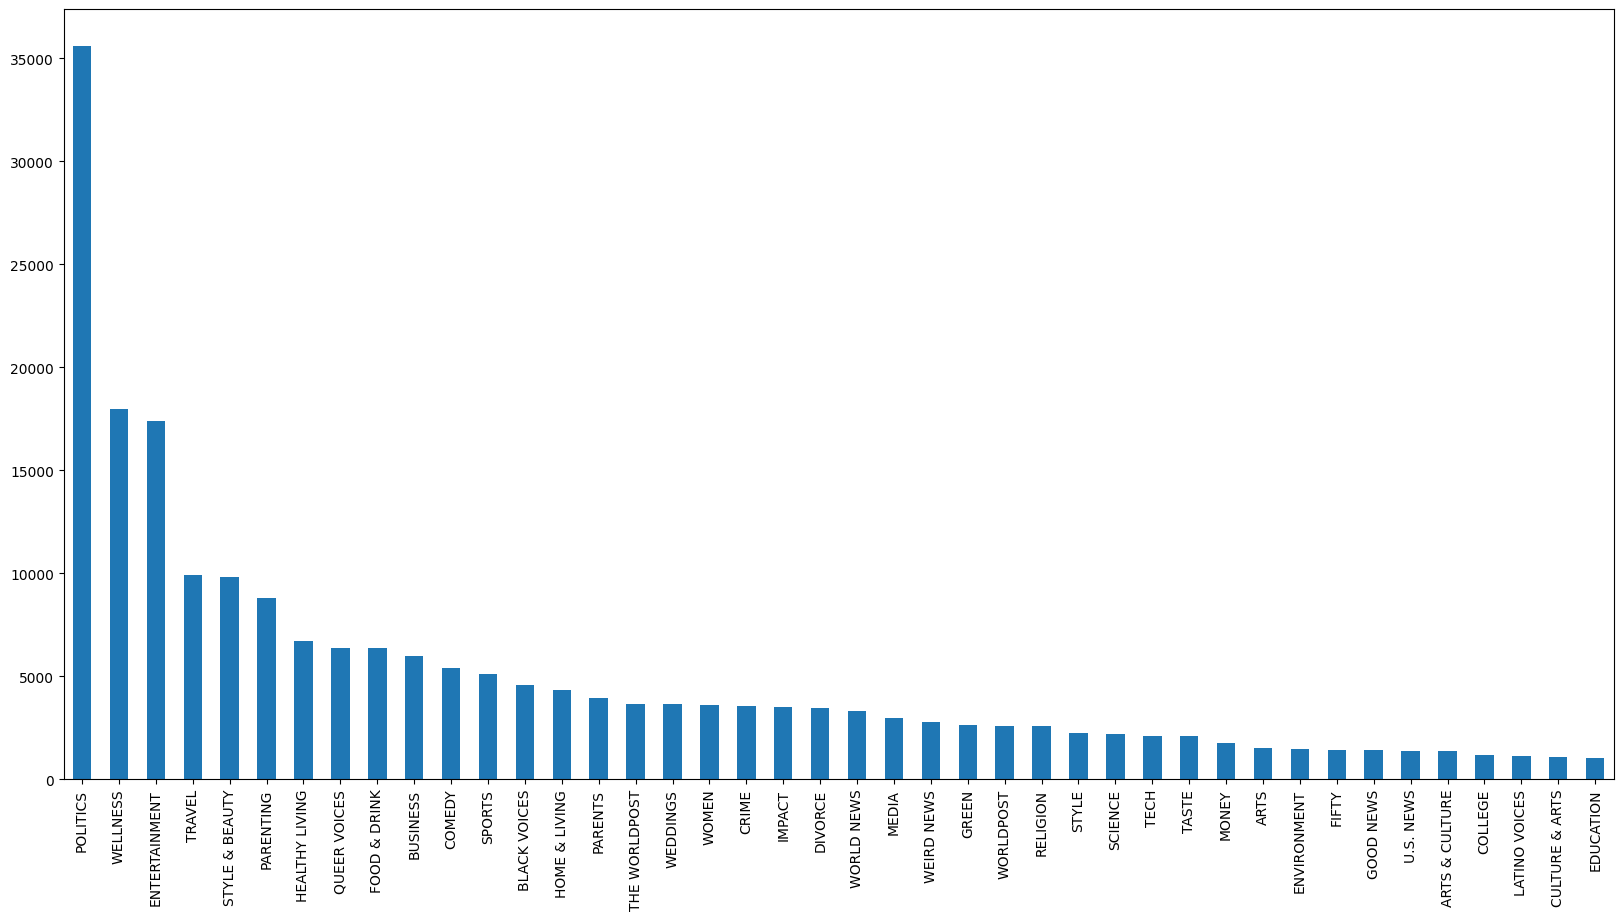

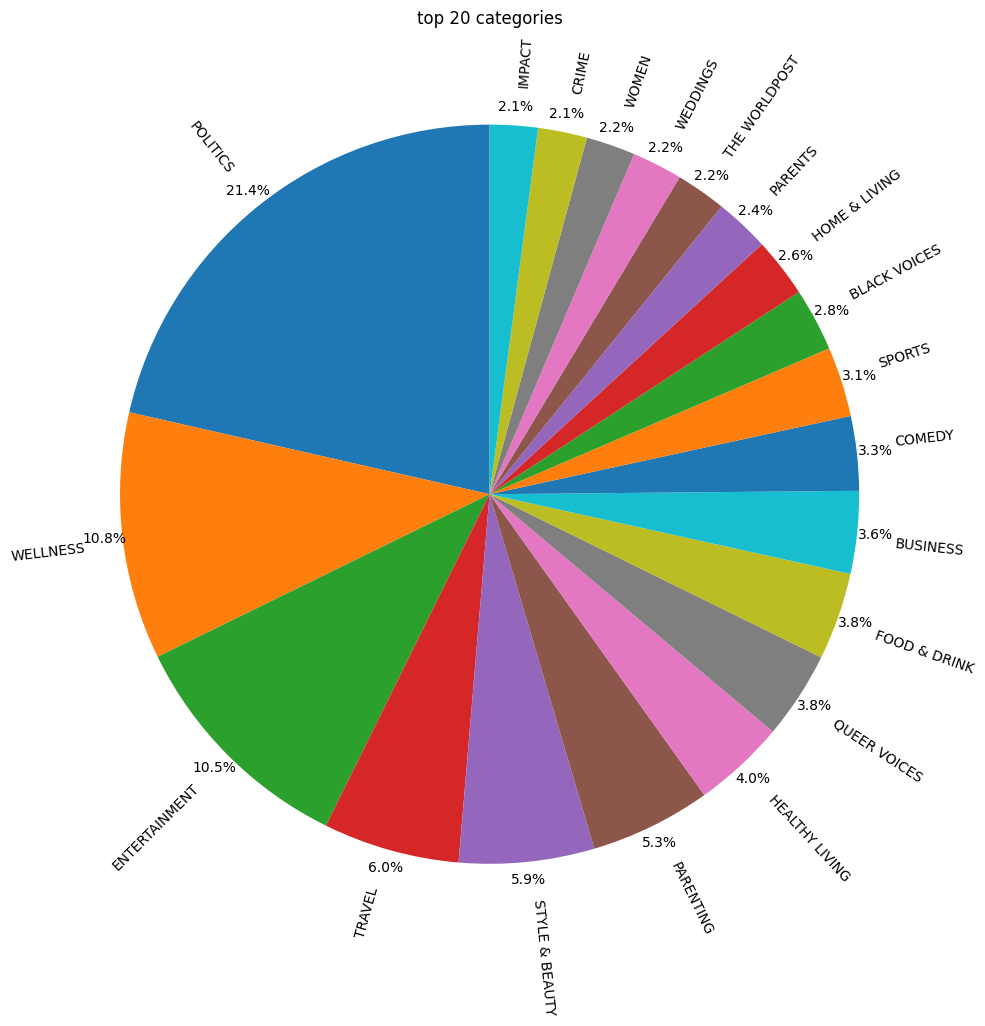

In [ ]:
categories_distrib(data)

Too many categories. Merging some of them seems to be convenient.

"QUEER VOICES" to "GROUPS VOICES"

"BLACK VOICES" to "GROUPS VOICES"

"LATINO VOICES" to "GROUPS VOICES"


"ARTS" to "ARTS & CULTURE"

"CULTURE & ARTS" to "ARTS & CULTURE"


"BUSINESS" to "BUSINESS & FINANCES"

"MONEY" to "BUSINESS & FINANCES"


"SCIENCE" to "SCIENCE & TECH"

"TECH" to "SCIENCE & TECH"


"COLLEGE" to "EDUCATION"


"STYLE" to "STYLE & BEAUTY"


"HEALTHY LIVING" to "WELLNESS"


"PARENTS" to "PARENTING"


"GREEN" to "ENVIRONMENT"

"TASTE" to "FOOD & DRINK"


"WORLDPOST" to "WORLD NEWS"

"THE WORLDPOST" to "WORLD NEWS"


"FIFTY" to "MISCELLANEOUS"

"GOOD NEWS" to "MISCELLANEOUS"

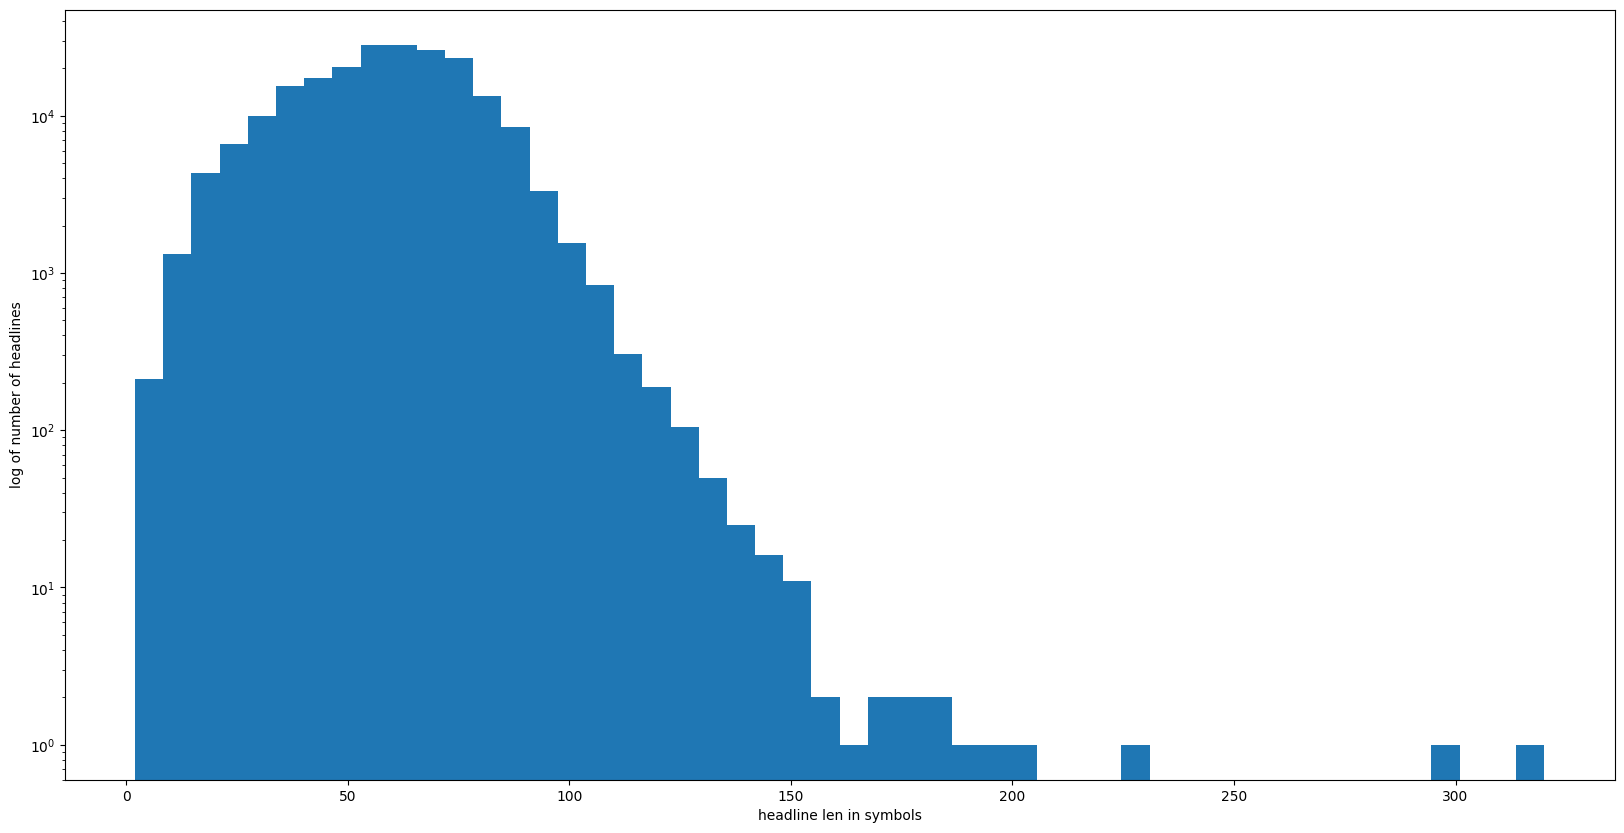

          category  headline_len_symbols_max  headline_len_symbols_min
0     BLACK VOICES                       320                         5
1    ENTERTAINMENT                       295                         5
2   HEALTHY LIVING                       228                         4
3   ARTS & CULTURE                       202                        11
4         POLITICS                       189                         4
5     QUEER VOICES                       182                         5
6             ARTS                       181                         7
7         BUSINESS                       180                         6
8           TRAVEL                       178                         3
9        EDUCATION                       172                        11
10         DIVORCE                       169                         5
11          SPORTS                       157                         3
12           STYLE                       151                        11
13   H

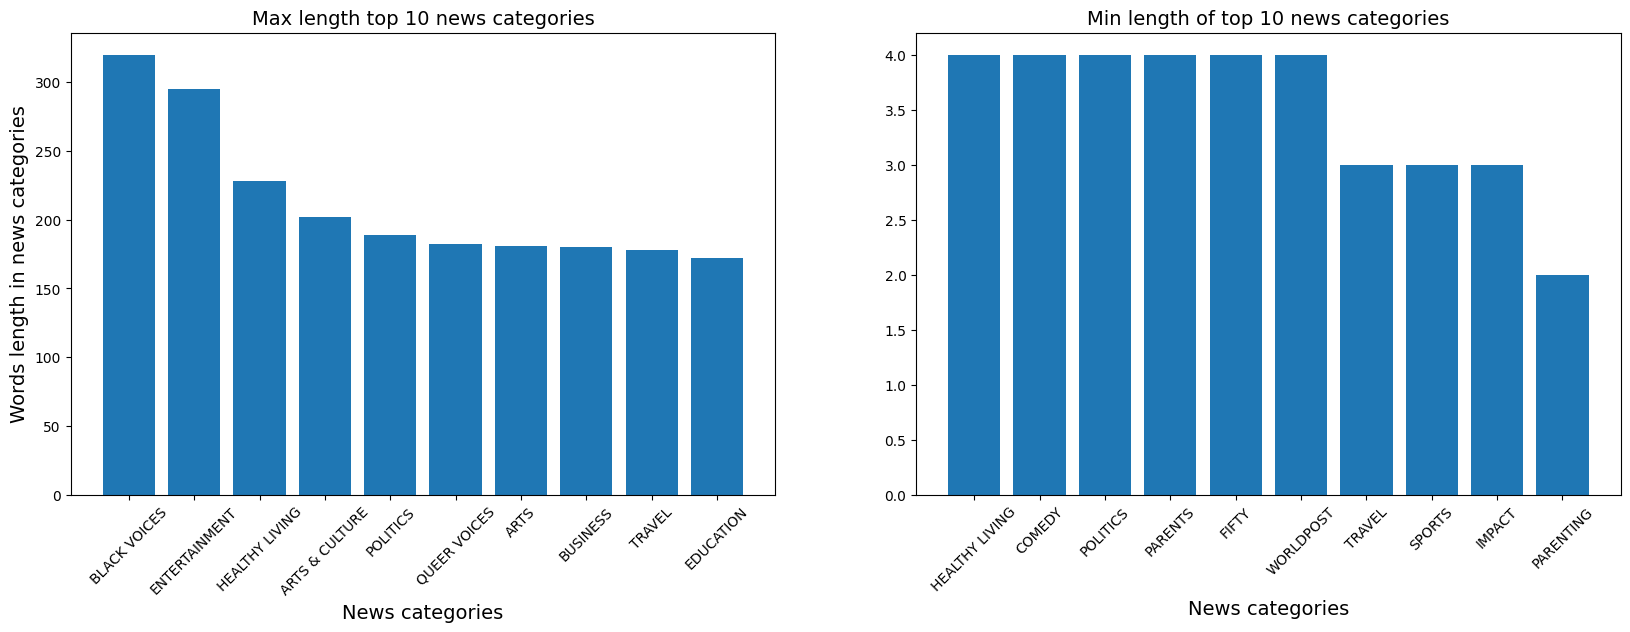

In [ ]:
min_max_len_symbols(data)

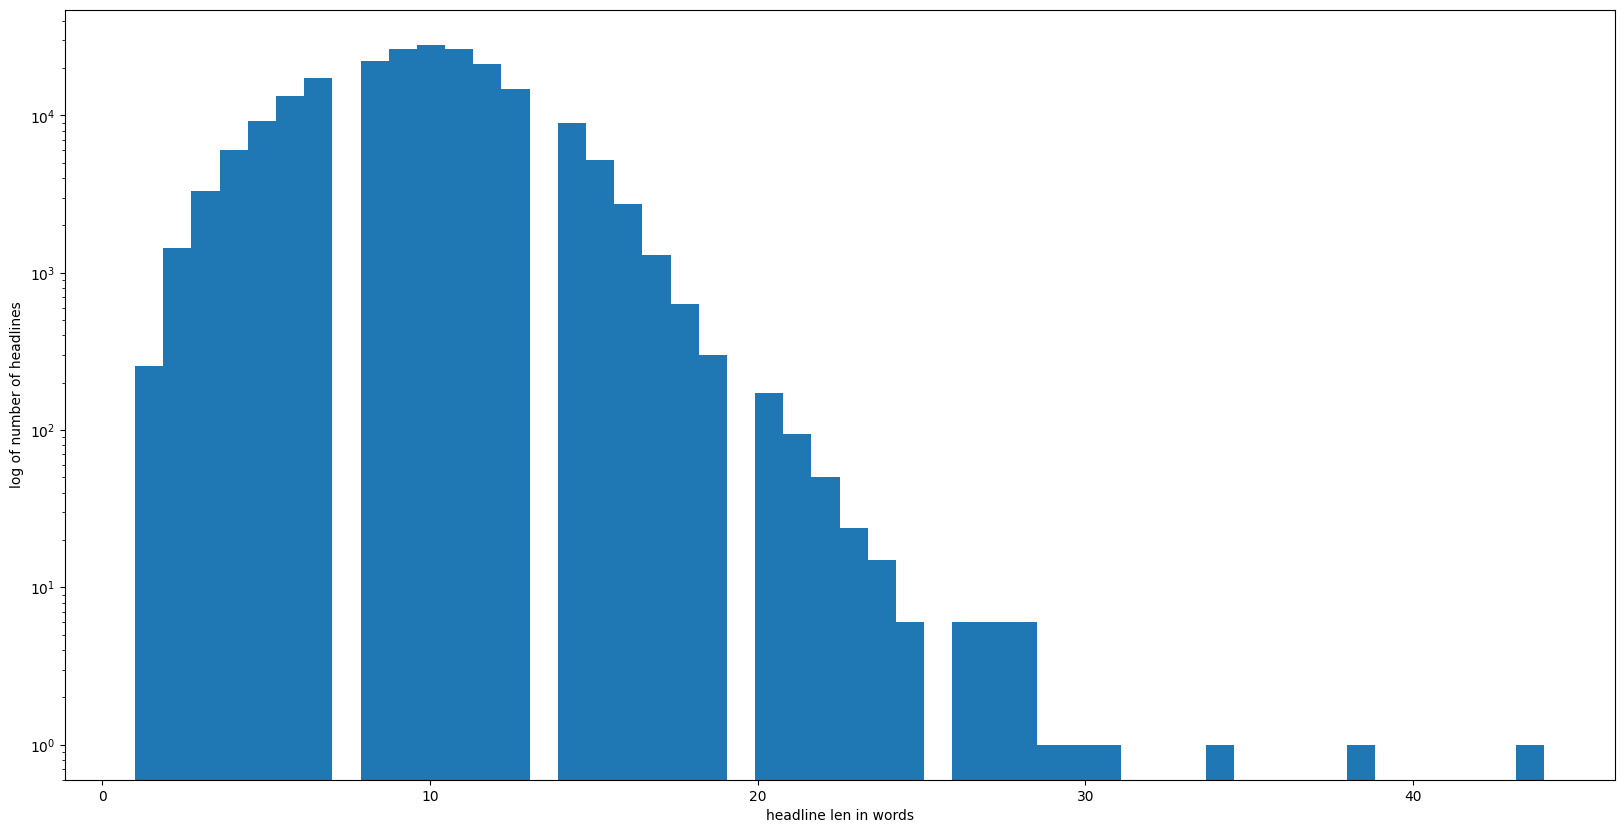

          category  headline_len_words_max  headline_len_words_min
0    ENTERTAINMENT                      44                       1
1   HEALTHY LIVING                      38                       1
2          DIVORCE                      31                       1
3   ARTS & CULTURE                      30                       2
4            GREEN                      29                       1
5           TRAVEL                      28                       1
6     QUEER VOICES                      28                       1
7        EDUCATION                      28                       1
8             ARTS                      28                       1
9           IMPACT                      27                       1
10        BUSINESS                      27                       1
11        POLITICS                      27                       1
12          SPORTS                      26                       1
13           MEDIA                      24                    

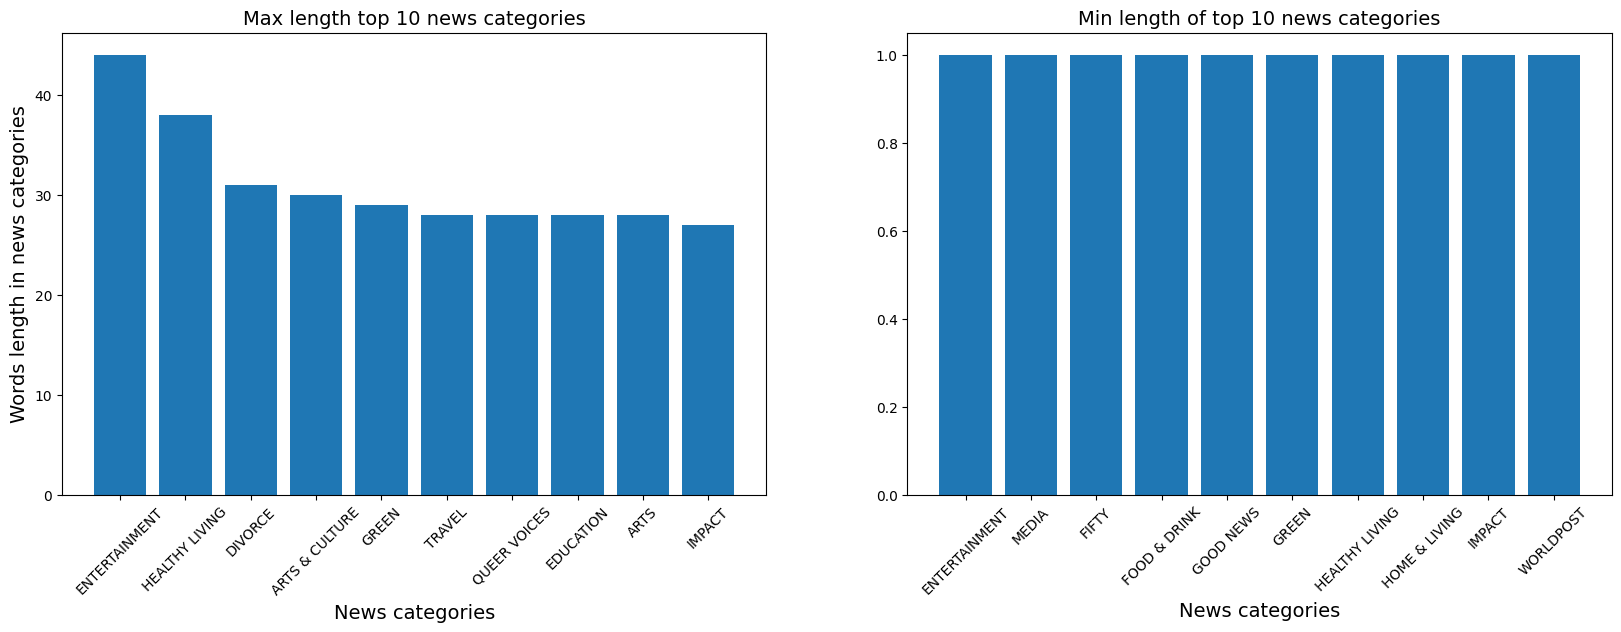

In [ ]:
min_max_len_words(data)

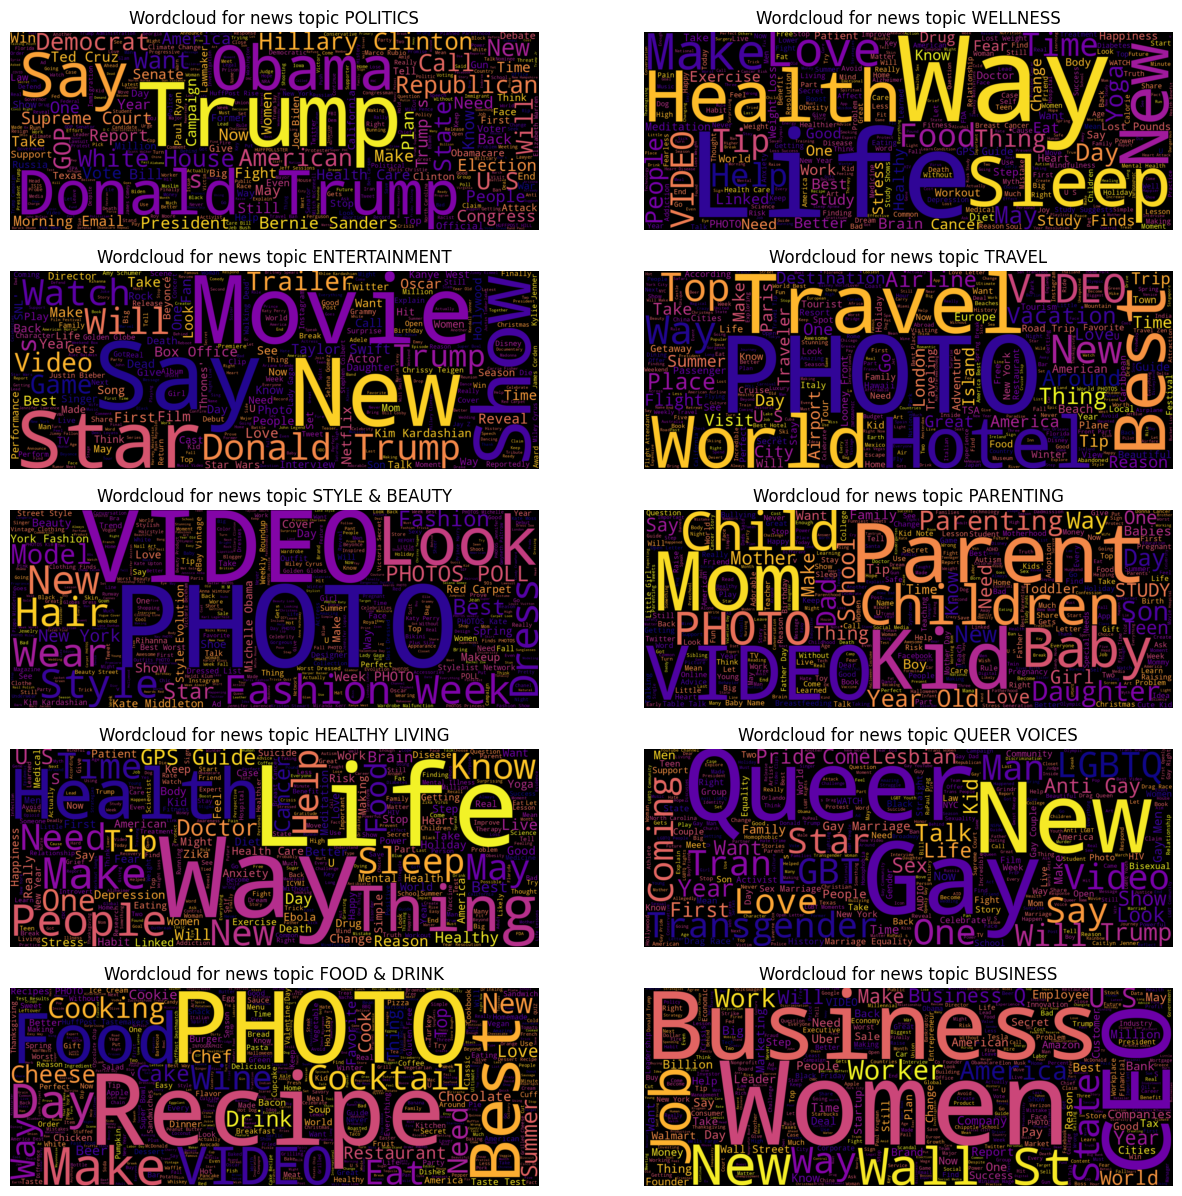

In [ ]:
word_clouds_top10(data)

# Dataset: BBC


http://mlg.ucd.ie/datasets/bbc.html



## data preparation

In [56]:
!unzip bbc-fulltext.zip -d bbc

Archive:  bbc-fulltext.zip
   creating: bbc/bbc/
   creating: bbc/bbc/entertainment/
  inflating: bbc/bbc/entertainment/289.txt  
  inflating: bbc/bbc/entertainment/262.txt  
  inflating: bbc/bbc/entertainment/276.txt  
  inflating: bbc/bbc/entertainment/060.txt  
  inflating: bbc/bbc/entertainment/074.txt  
  inflating: bbc/bbc/entertainment/048.txt  
  inflating: bbc/bbc/entertainment/114.txt  
  inflating: bbc/bbc/entertainment/100.txt  
  inflating: bbc/bbc/entertainment/128.txt  
  inflating: bbc/bbc/entertainment/316.txt  
  inflating: bbc/bbc/entertainment/302.txt  
  inflating: bbc/bbc/entertainment/303.txt  
  inflating: bbc/bbc/entertainment/317.txt  
  inflating: bbc/bbc/entertainment/129.txt  
  inflating: bbc/bbc/entertainment/101.txt  
  inflating: bbc/bbc/entertainment/115.txt  
  inflating: bbc/bbc/entertainment/049.txt  
  inflating: bbc/bbc/entertainment/075.txt  
  inflating: bbc/bbc/entertainment/061.txt  
  inflating: bbc/bbc/entertainment/277.txt  
  inflating: bb

In [57]:
main_directory = 'bbc/bbc'
categories = ['business', 'politics', 'sport', 'tech', 'entertainment']
data = []

for category in categories:
    category_path = os.path.join(main_directory, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                headline = file.readline().strip()
            data.append([headline, category])

csv_filename = 'bbc.csv'
with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['headline', 'category']
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()
    for row in data:
        csv_writer.writerow({'headline': row[0], 'category': row[1]})

In [58]:
data = pd.read_csv('bbc.csv')
data.sample(3)

headline       category
1322  Johnson too strong for GB runners          sport
2137   Berlin cheers for anti-Nazi film  entertainment
1242   Wolves appoint Hoddle as manager          sport

In [59]:
data_ = data
data_['category'] = data_['category'].apply(process_categories_names)
data_['headline'] = data_['headline'].apply(process_headline)
print(data_.sample(5))
data_.to_csv('bbc_processed.csv', sep='\t')

                               headline       category
49    barclays profits hit record level       business
1204  moyes u-turn on beattie dismissal          sport
1469    millions to miss out on the net           tech
2055    lost doors frontman movie found  entertainment
2142  singer s film to show at festival  entertainment


In [61]:
dataset_analysis(
    data,
    'bbc_processed.csv',
    'bbc news',
    'This dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas (business, entertainment, politics, sport, tech) from 2004-2005.',
    'http://mlg.ucd.ie/datasets/bbc.html',
    'https://www.dropbox.com/scl/fi/k0jew1q7pgbwji3onbgsq/bbc_processed.csv?rlkey=6v7cqxxcod0ktvdvuypgh2uin&dl=0'
)

## plots

In [ ]:
data = missing_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  2225 non-null   object
 1   category  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None
No Missing Data
Number of empty headlines: 0
New data len: 2225


In [ ]:
duplicates_info(data)

number of duplicated headline: 129
number of duplicated headline&category: 129
Series([], Name: category, dtype: object)


number of categories: 5
categories:
['business' 'politics' 'sport' 'tech' 'entertainment']
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


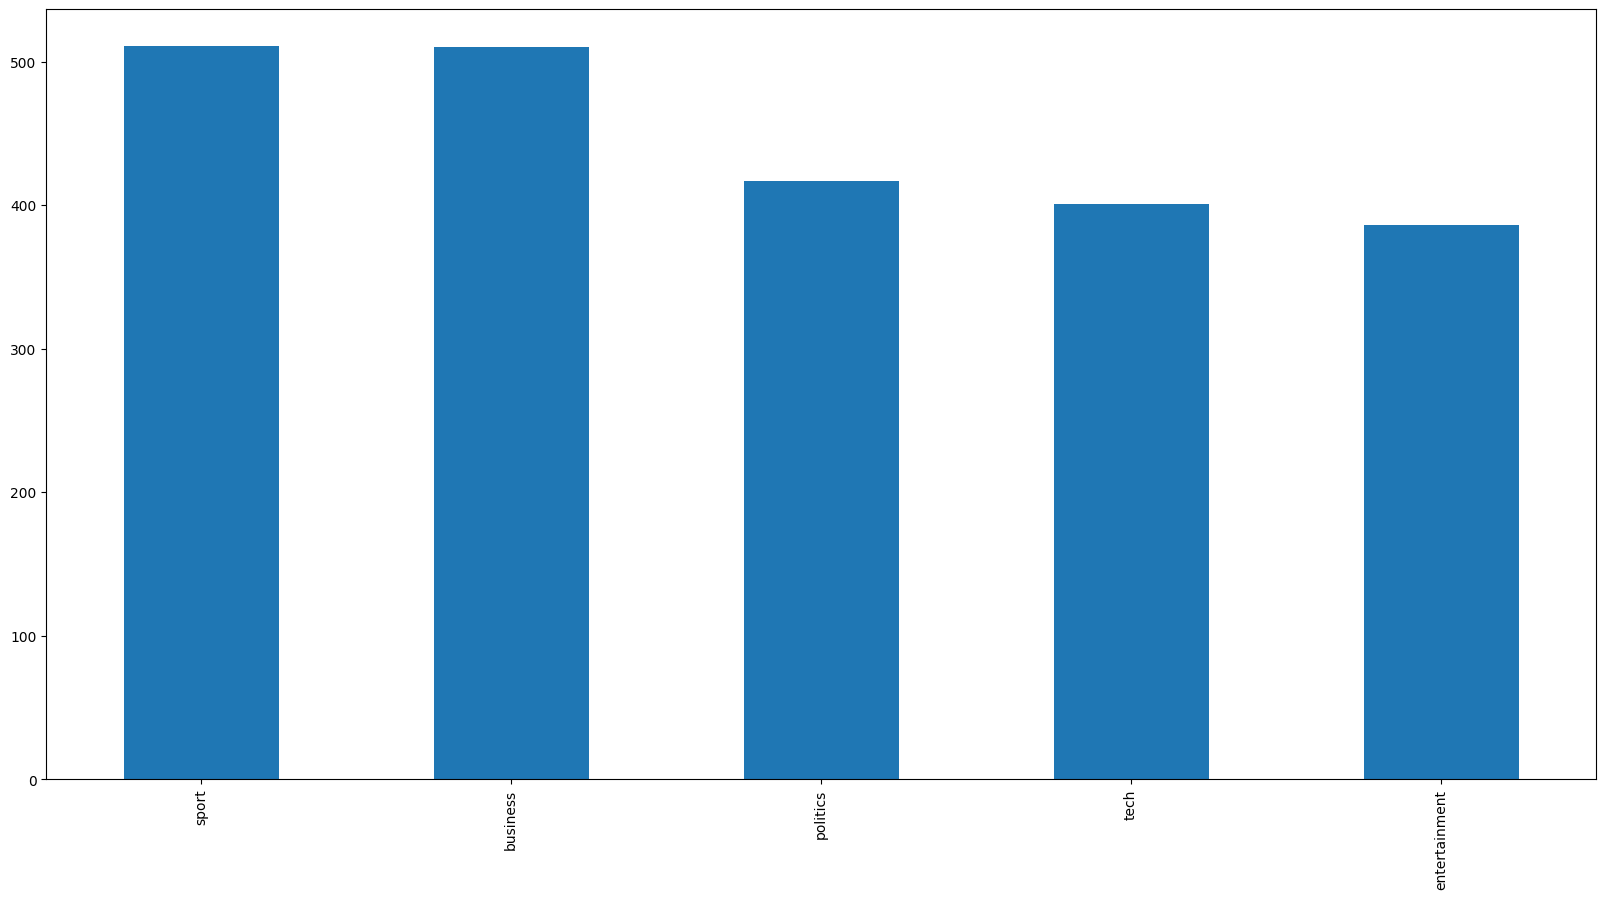

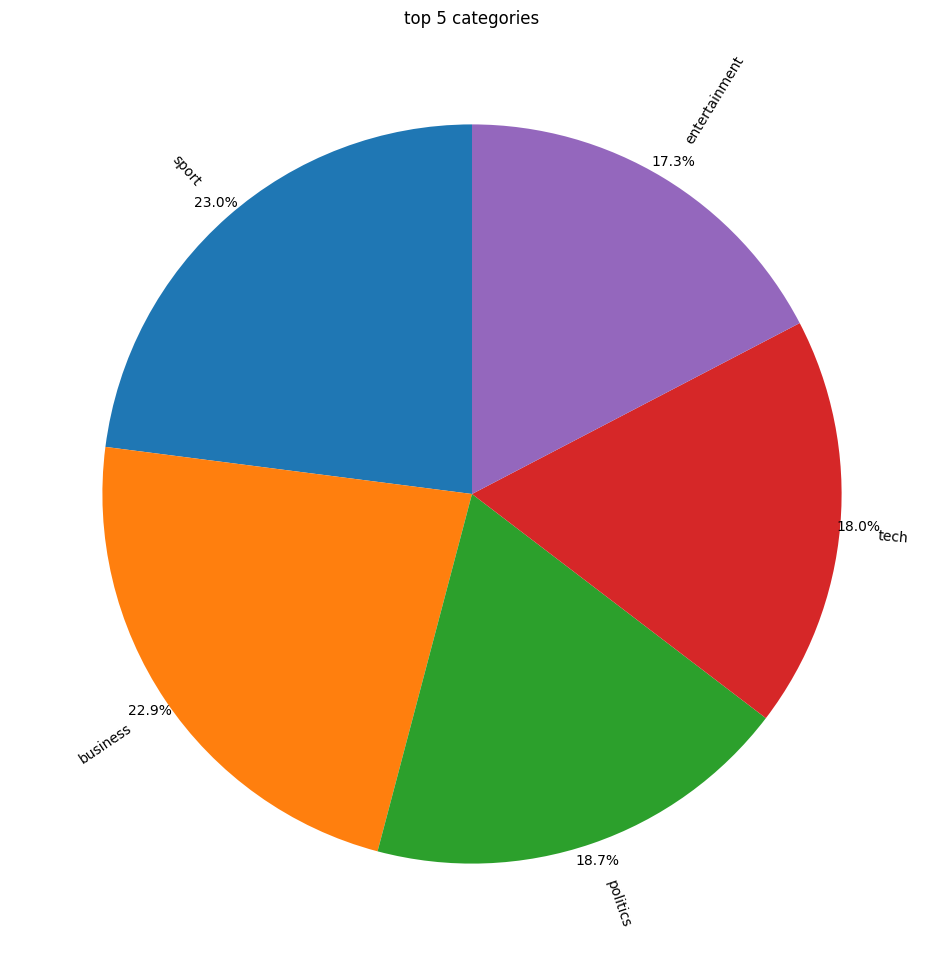

In [ ]:
categories_distrib(data)

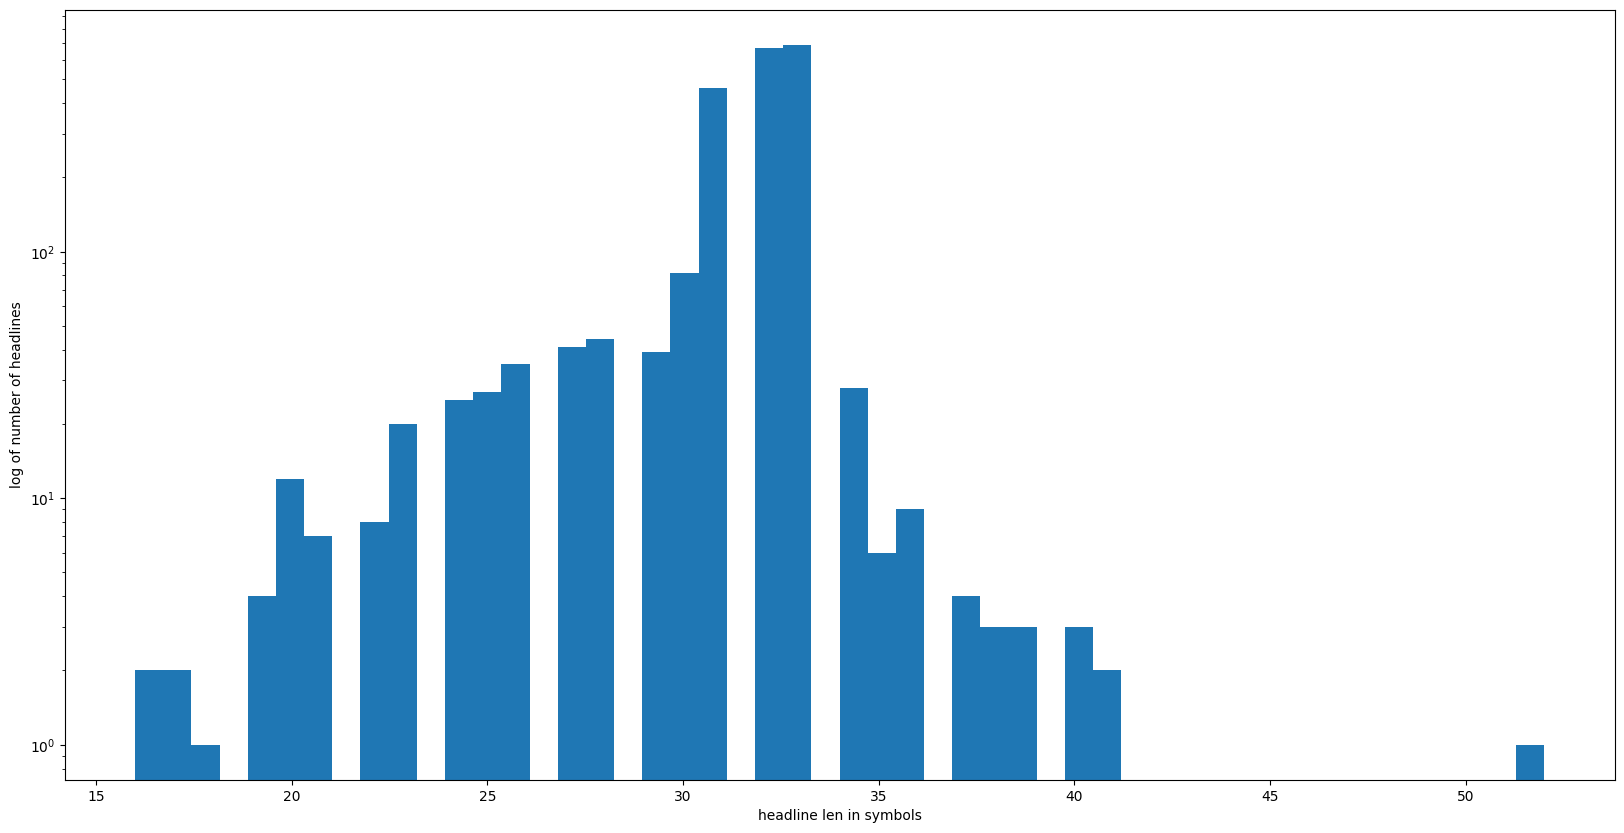

        category  headline_len_symbols_max  headline_len_symbols_min
0  entertainment                        52                        20
1       politics                        41                        21
2       business                        40                        23
3          sport                        40                        16
4           tech                        37                        22


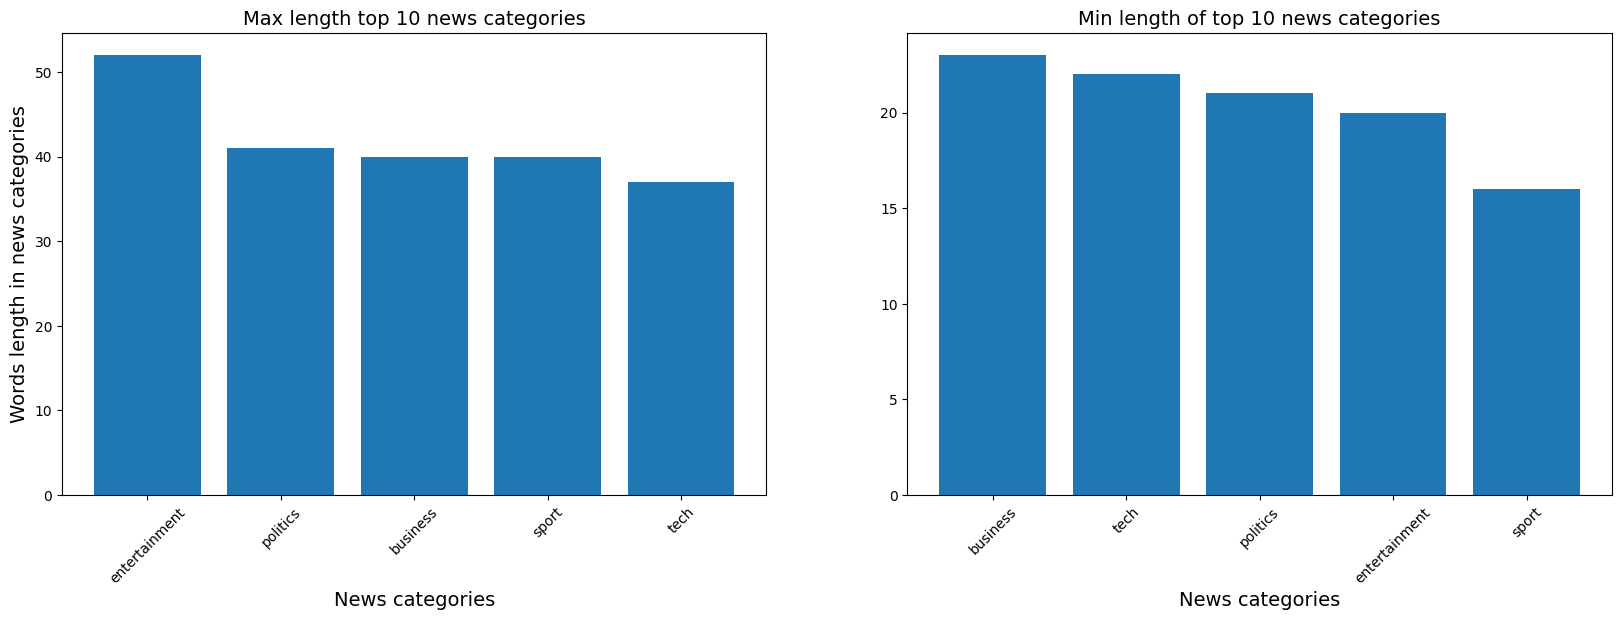

In [ ]:
min_max_len_symbols(data)

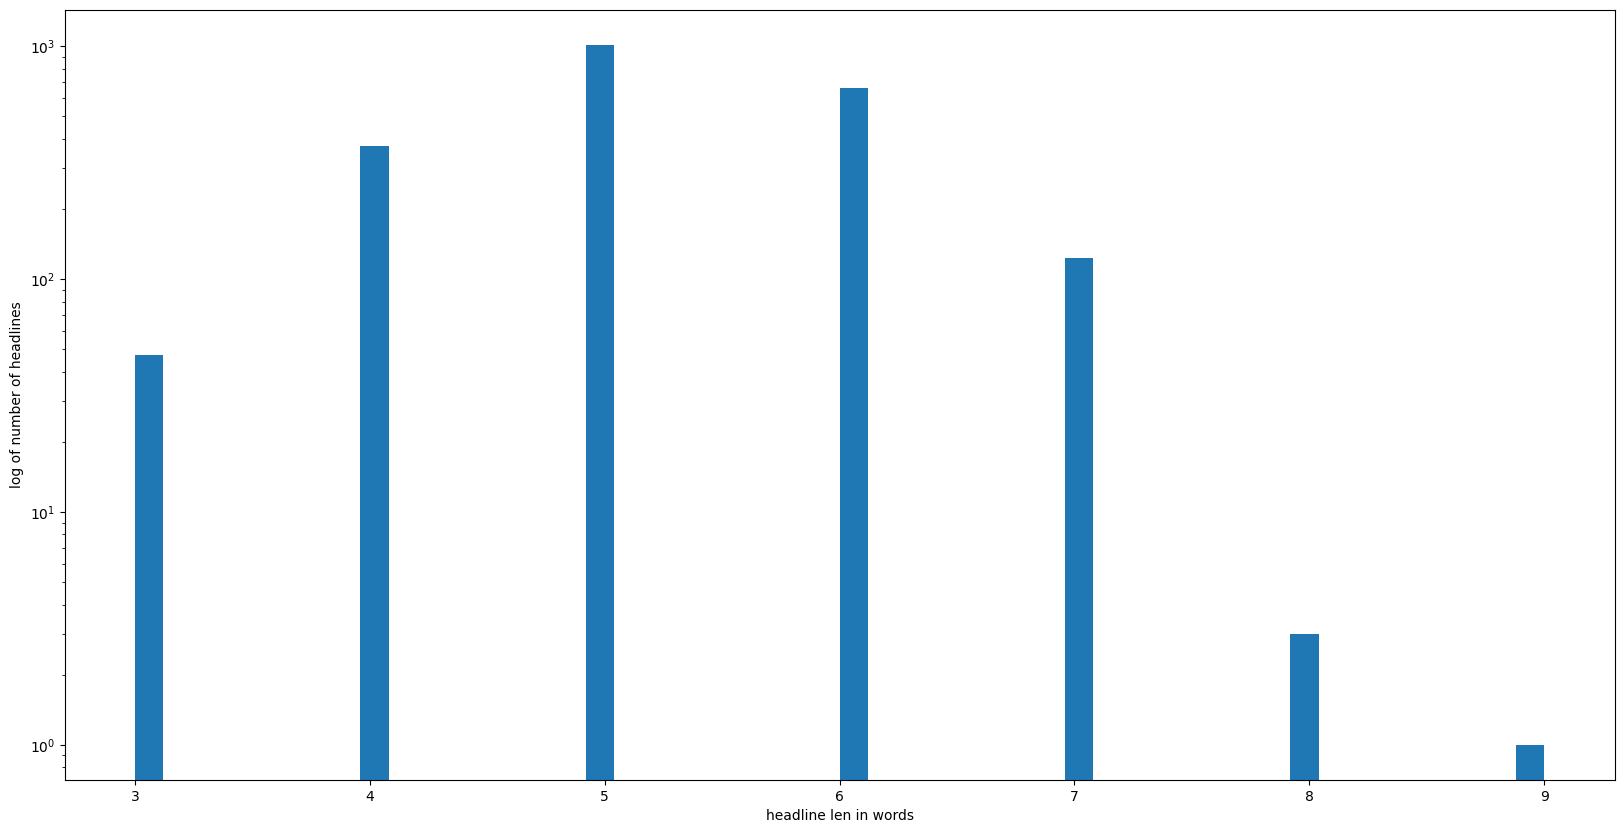

        category  headline_len_words_max  headline_len_words_min
0  entertainment                       9                       4
1           tech                       8                       3
2       business                       7                       3
3       politics                       7                       3
4          sport                       7                       3


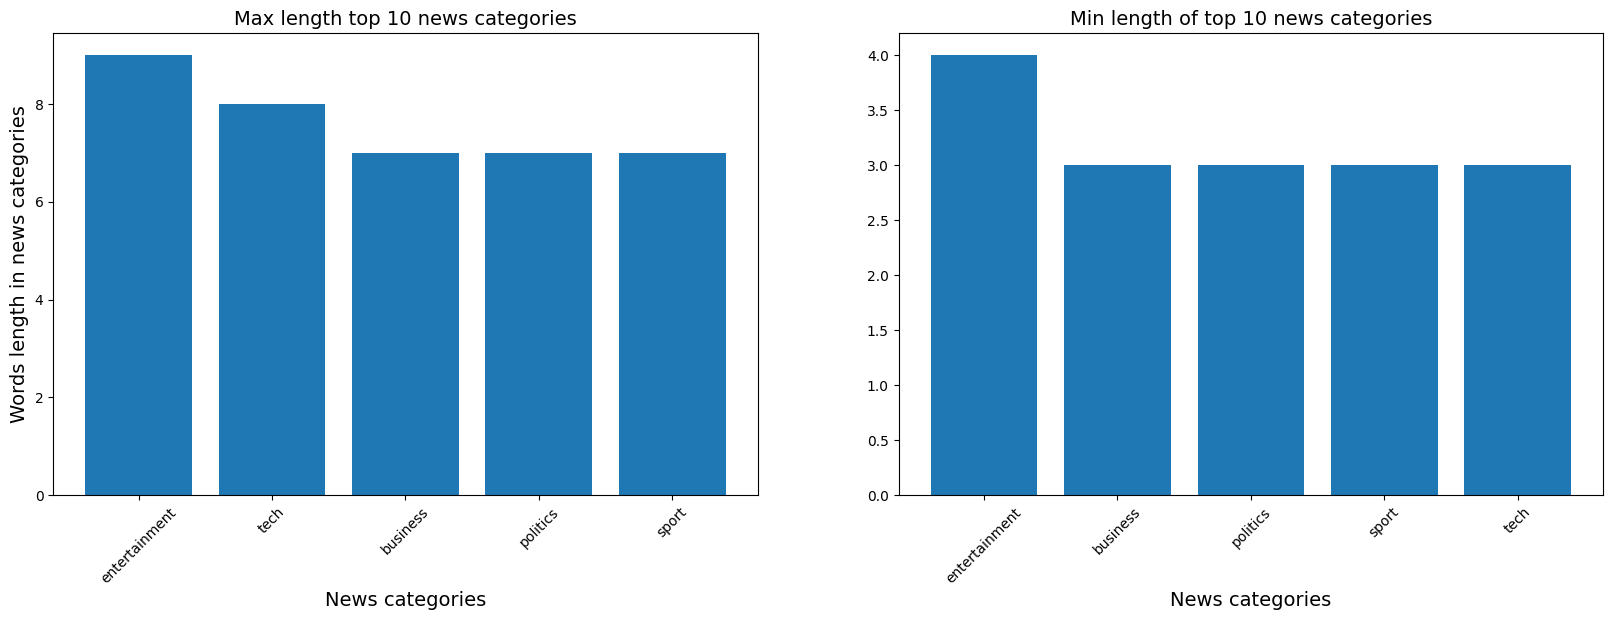

In [ ]:
min_max_len_words(data)

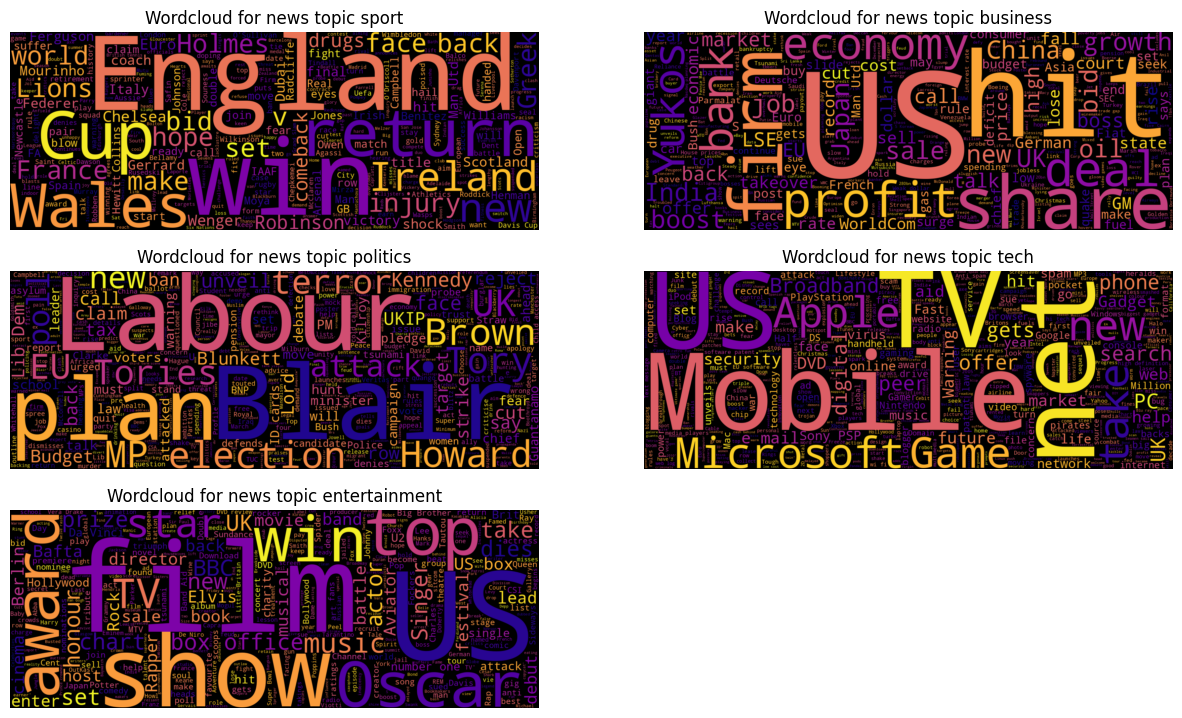

In [ ]:
word_clouds_top10(data)

# Панорама

## data preparation

In [52]:
column_names = ['headline', 'category']
data = pd.read_csv(
    'panorama.csv',
    sep=';',
    encoding='utf-8',
    header=None,
    names=column_names
)
data.sample(2)

headline  category
1346  Анатолий Вассерман станет лицом новой коллекци...  Общество
6593  Арестович: «Релокация украинского правительств...  Политика

In [53]:
data['category'] = ['panorama' for _ in range(len(data))]

In [55]:
dataset_analysis(
    data,
    'panorama.csv',
    'Panorama Dataset',
    'Funny fake news in russian.',
    'no permission to share',
    'no permission to share'
)

## plots

In [ ]:
# In this case, the plots are not very exciting, since all news corresponds to the same category "panorama"

# AG's corpus of news articles

http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html

## data preparation

In [ ]:
import bz2

with bz2.BZ2File('newsSpace.bz2', 'rb') as f_in:
    with open('output_file.txt', 'wb') as f_out:
        f_out.write(f_in.read())

In [ ]:
with open('output_file.txt', 'r', encoding='latin1') as f:
    lines = f.readlines()

In [ ]:
for s in lines[:10]:
    print(s)

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_stocks_week_dc	Wall St. Pullback Reflects Tech Blowout (Reuters)	none	Business	Reuters - Wall Street's long-playing drama,\

"Waiting for Google," is about to reach its final act, but its\

stock market debut is ending up as more of a nostalgia event\

than the catalyst for a new era.	5	0000-00-00 00:00:00	\N

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/markets_bears_dc	Wall St. Bears Claw Back Into the Black (Reuters)	none	Business	Reuters - Short-sellers, Wall Street's dwindling\

band of ultra-cynics, are seeing green again.	5	0000-00-00 00:00:00	\N

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_mergers_dc	Carlyle Looks Toward Commercial Aerospace (Reuters)	none	Business	Reuters -

In [ ]:
lines = (''.join(lines)).split('\\N')
for s in lines[:10]:
    print(s)

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_stocks_week_dc	Wall St. Pullback Reflects Tech Blowout (Reuters)	none	Business	Reuters - Wall Street's long-playing drama,\
"Waiting for Google," is about to reach its final act, but its\
stock market debut is ending up as more of a nostalgia event\
than the catalyst for a new era.	5	0000-00-00 00:00:00	

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/markets_bears_dc	Wall St. Bears Claw Back Into the Black (Reuters)	none	Business	Reuters - Short-sellers, Wall Street's dwindling\
band of ultra-cynics, are seeing green again.	5	0000-00-00 00:00:00	

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_mergers_dc	Carlyle Looks Toward Commercial Aerospace (Reuters)	none	Business	Reuters - Private

In [ ]:
lines = [l.replace('\n', ' ') for l in lines]
# lines = [l.replace('*http', '\thttp') for l in lines]
for s in lines[:10]:
    print(s)

Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_stocks_week_dc	Wall St. Pullback Reflects Tech Blowout (Reuters)	none	Business	Reuters - Wall Street's long-playing drama,\ "Waiting for Google," is about to reach its final act, but its\ stock market debut is ending up as more of a nostalgia event\ than the catalyst for a new era.	5	0000-00-00 00:00:00	
 Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/markets_bears_dc	Wall St. Bears Claw Back Into the Black (Reuters)	none	Business	Reuters - Short-sellers, Wall Street's dwindling\ band of ultra-cynics, are seeing green again.	5	0000-00-00 00:00:00	
 Yahoo Business	http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_mergers_dc	Carlyle Looks Toward Commercial Aerospace (Reuters)	none	Business	Reuters - Private

In [ ]:
for s in lines[-10:]:
    print(s)

 The Motley Fool	http://feeds.fool.com/~r/usmf/foolwatch/~3/238333914/the-century-mark.aspx	The Century Mark	none	Business	Give CAPS players who score 100 points in 100 days their due.\ <p><a href="http://feeds.fool.com/~a/usmf/foolwatch?a=yVJ2ns"><img src="http://feeds.fool.com/~a/usmf/foolwatch?i=yVJ2ns" border="0"></img></a></p><img src="http://feeds.fool.com/~r/usmf/foolwatch/~4/238333914" height="1" width="1"/>	5	2008-02-20 22:53:43	
 PHPDeveloper.org	http://www.phpdeveloper.org/news/9671	DevShed: Building a Complete Web Searching Class with Yahoo Web Services and PHP 5	none	Software and Developement	<p>\ DevShed finishes up their series looking at making a search engine with the Yahoo! web services in PHP5 in <a href="http://www.devshed.com/c/a/PHP/Building-a-Complete-Web-Searching-Class-with-Yahoo-Web-Services-and-PHP-5/">this last look</a> at using the functionality they've created so far to make a more improved search.\ </p>\ <blockquote>\ This last installment of the series w

In [ ]:
# source      | varchar(32)  |      | PRI |                   |       |
# | url         | varchar(255) |      | PRI |                   |       |
# | title       | text         | YES  | MUL | NULL              |       |
# | image       | varchar(255) | YES  |     | NULL              |       |
# | category    | varchar(32)  |      | PRI |                   |       |
# | description | text         | YES  |     | NULL              |       |
# | rank        | int(11)      | YES  |     | NULL              |       |
# | pubdate     | timestamp    | YES  |     | CURRENT_TIMESTAMP |       |
# | video       | varchar(255) | YES  |     | NULL              |       |
# +------

In [ ]:
data_list = [row.split('\t') for row in lines]
column_names = [
    'source', 'url', 'title', 'image', 'category', 'description', 'rank', 'pubdate', 'video'
]
print(len(column_names))

for (c, d) in zip(column_names, data_list[0]):
    print(f'{c}: {d}')

9
source: Yahoo Business
url: http://us.rd.yahoo.com/dailynews/rss/business/*http://story.news.yahoo.com/news?tmpl=story2&u=/nm/20040814/bs_nm/column_stocks_week_dc
title: Wall St. Pullback Reflects Tech Blowout (Reuters)
image: none
category: Business
description: Reuters - Wall Street's long-playing drama,\ "Waiting for Google," is about to reach its final act, but its\ stock market debut is ending up as more of a nostalgia event\ than the catalyst for a new era.
rank: 5
pubdate: 0000-00-00 00:00:00
video: 


In [ ]:
i = 0
for r in data_list:
    if len(r) != 9:
        # print(r)
        # print('___________')
        i += 1
print('wrong len in', i, 'out of', len(data_list))
print(i / len(data_list) * 100, '%')

wrong len in 65488 out of 1308442
5.00503652435492 %


In [ ]:
i = 0
for r in data_list:
    if len(r) != 9:
        print(len(r))
        print(r)
        print('___________')
        i += 1
    if i == 50:
        break

10
[' CNET\\', '', 'http://www.kuro5hin.org/story/2004/8/13/155640/431', 'Customers of Telco Companies Face Privacy Breach', 'none', 'Sci/Tech', 'A security advisory posted on Bugtraq demonstrates how hackers can compromise customers of T-mobile wireless and Verizon (landline) voicemail boxes. The advisory talks about the use of Caller-ID spoofing the customers number, allowing a bypass of the PIN code since the voicemail thinks that the customer is calling to check their own voicemail. According to Secure Science Corporation, there has been no response from the vendors. Comments have been posted that T-Mobile has optional PIN code protection off by default. Better turn it on. ', '5', '2004-08-18 22:59:06', '']
___________
10
[' CNET\\', '', 'http://www.kuro5hin.org/story/2004/8/11/18044/9755', 'Mozilla To Add Support For XForms, World Yawns', 'none', 'Sci/Tech', "It's ironic that Microsoft could help further cement its dominance in the browser market by joining its largest rival in an

In [ ]:
filtered_data_list = [r for r in data_list if len(r) == 9]
print('new len:', len(filtered_data_list))
print(len(filtered_data_list) / len(data_list) * 100, '%')

new len: 1242954
94.99496347564508 %


In [ ]:
data = pd.DataFrame(filtered_data_list, columns=column_names)
# data = data[['title', 'category']] # , 'rank']]
data.sample(3)

source  \
129551                   Reuters   
1238824   New York Times Science   
120627    BBC News entertainment   

                                                       url  \
129551       http://www.rte.ie/business/2004/0920/oil.html   
1238824  http://www.nytimes.com/2008/02/19/health/19agi...   
120627   http://news.bbc.co.uk/go/click/rss/0.91/public...   

                                                   title  \
129551          YUKOS Cuts China Supplies, Oil Above $46   
1238824  Gentlemen, 5 Easy Steps to Living Long and Well   
120627                  Star 'regrets accusers payments'   

                                                     image       category  \
129551                                                           Business   
1238824                                               none       Sci/Tech   
120627   http___newsimg.bbc.co.uk_media_images_39744000...  Entertainment   

                                               description rank  \
129551   Oil prices broke above $46 on Monday after Rus...    5   
1238824  Five behaviors in elderly men are associated n...    5   
120627   Michael Jackson wishes he had fought previous ...    5   

                     pubdate video  
129551   2004-09-21 09:13:15        
1238824  2008-02-19 11:19:40        
120627   2004-09-19 02:08:21

In [ ]:
data.rename(columns={'title': 'headline'}, inplace=True)

## plots

In [ ]:
data = missing_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242954 entries, 0 to 1242953
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   headline  1242954 non-null  object
 1   category  1242954 non-null  object
dtypes: object(2)
memory usage: 19.0+ MB
None
No Missing Data
Number of empty headlines: 0
New data len: 1242954


In [ ]:
duplicates_info(data)

number of duplicated headline: 430619
number of duplicated headline&category: 232094
headline
                                                                  [U.S., Sports, World, Sci/Tech, Business, Health]
 $2 Million Airtime, $13 Ad                                                            [Sci/Tech, Sports, Business]
 $3 Million Frozen in Cyber-Fraud Case                                                         [Sci/Tech, Business]
 $35 Billion Boost In Works for Kids' Health Care                                                    [Health, U.S.]
 'Best-Kept Secret' For HIV-Free Africa                                                             [World, Health]
                                                                                        ...                        
âPharmacyâ items to bring Â£11.1million                                            [Entertainment, Top Stories]
âSpywareâ Under Attack by Government                                     [Entertainment, S

number of categories: 14
categories:
['Business' 'Sci/Tech' 'Software and Developement' 'Entertainment'
 'Sports' 'U.S.' 'World' 'Health' 'Top News' 'Europe' 'Italia'
 'Top Stories' 'Toons' 'Music Feeds']
World                        186674
Sci/Tech                     153595
Entertainment                137226
Business                     134223
Italia                       133345
Sports                       118103
Top News                     104261
Europe                        90555
Top Stories                   61579
U.S.                          47671
Health                        42621
Software and Developement     17454
Toons                          8015
Music Feeds                    7632
Name: category, dtype: int64


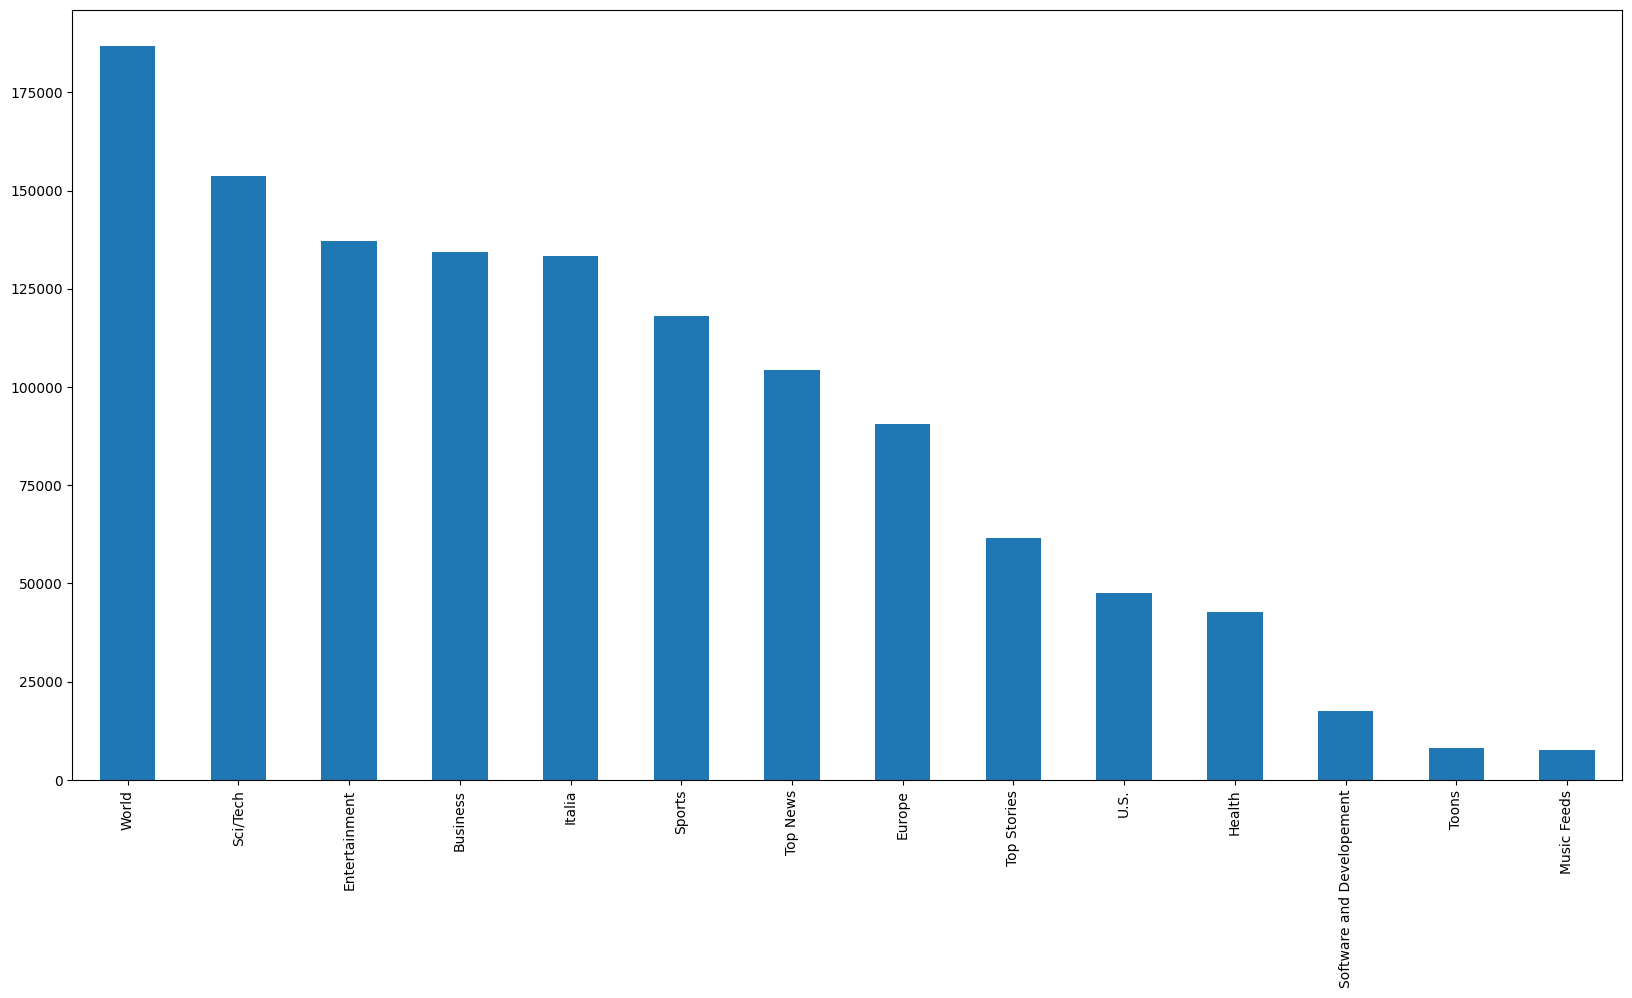

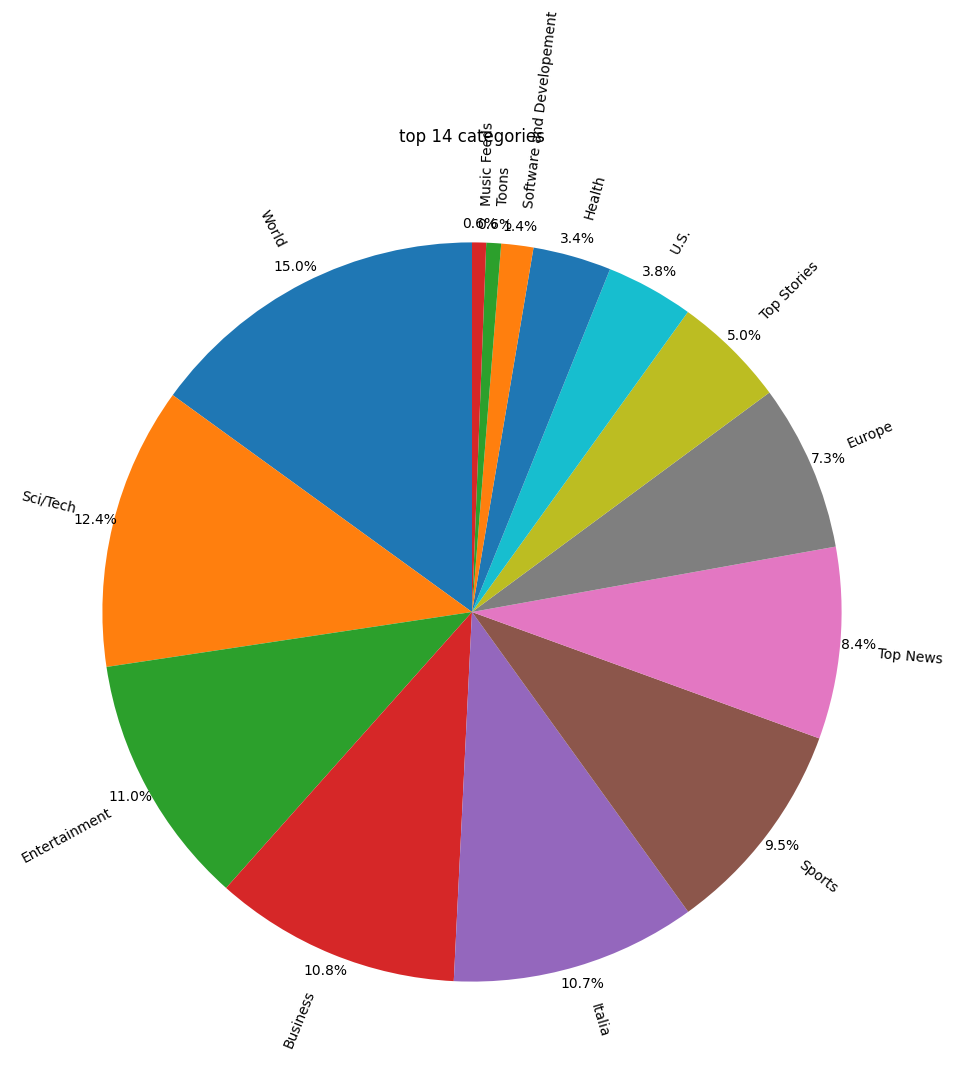

In [ ]:
categories_distrib(data)

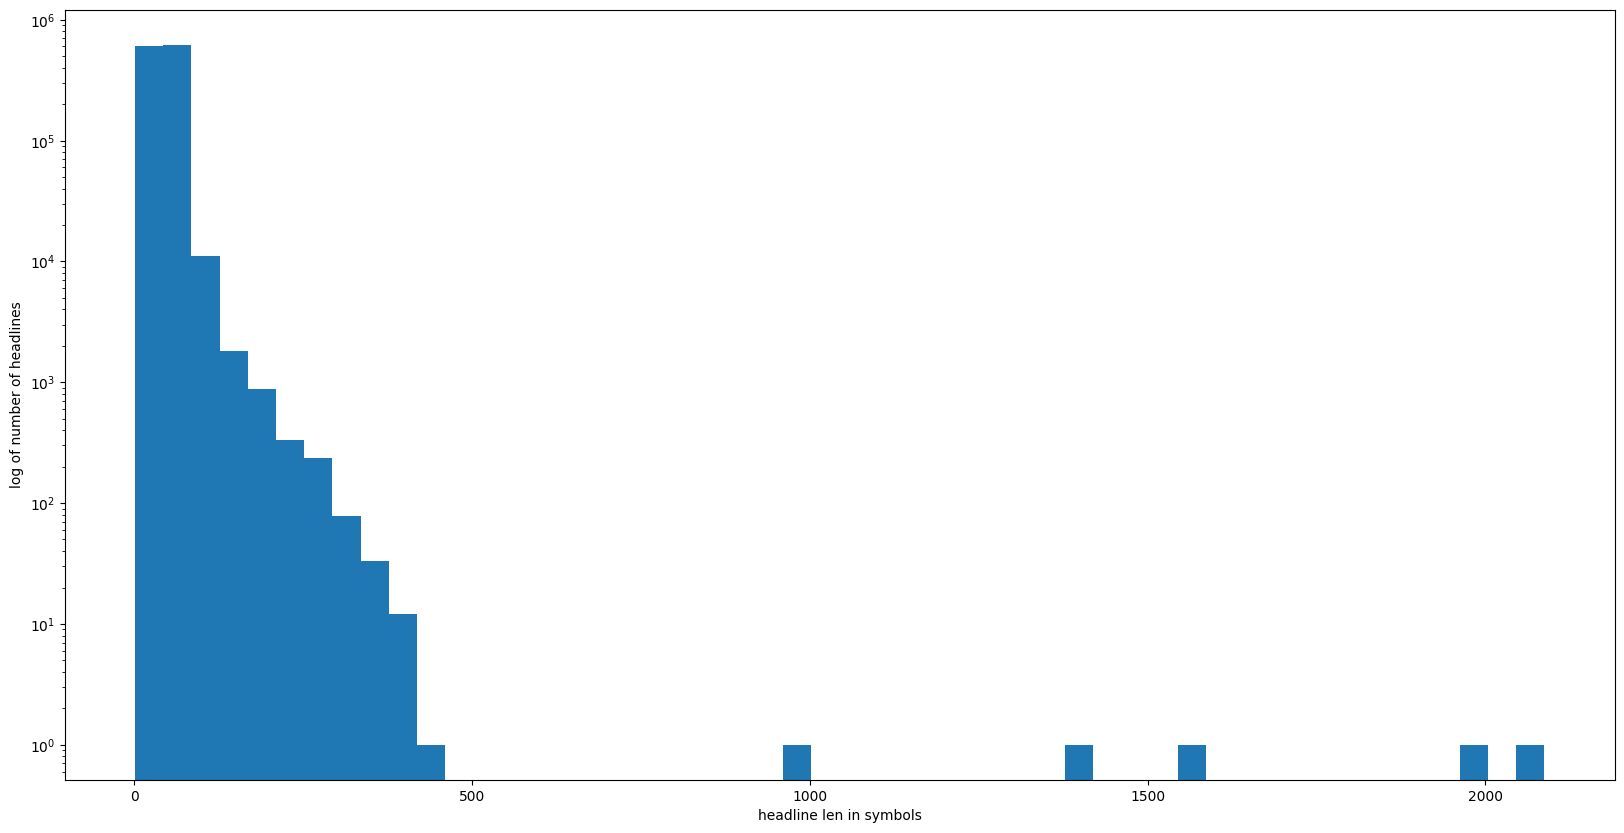

                     category  headline_len_symbols_max  \
0                       World                      2087   
1                      Sports                      1986   
2                      Italia                      1572   
3                 Music Feeds                       300   
4                    Sci/Tech                       255   
5                    Business                       163   
6               Entertainment                       163   
7                      Health                       163   
8                        U.S.                       163   
9                      Europe                       162   
10                   Top News                       151   
11  Software and Developement                       147   
12                Top Stories                       110   
13                      Toons                        58   

    headline_len_symbols_min  
0                          1  
1                          2  
2                    

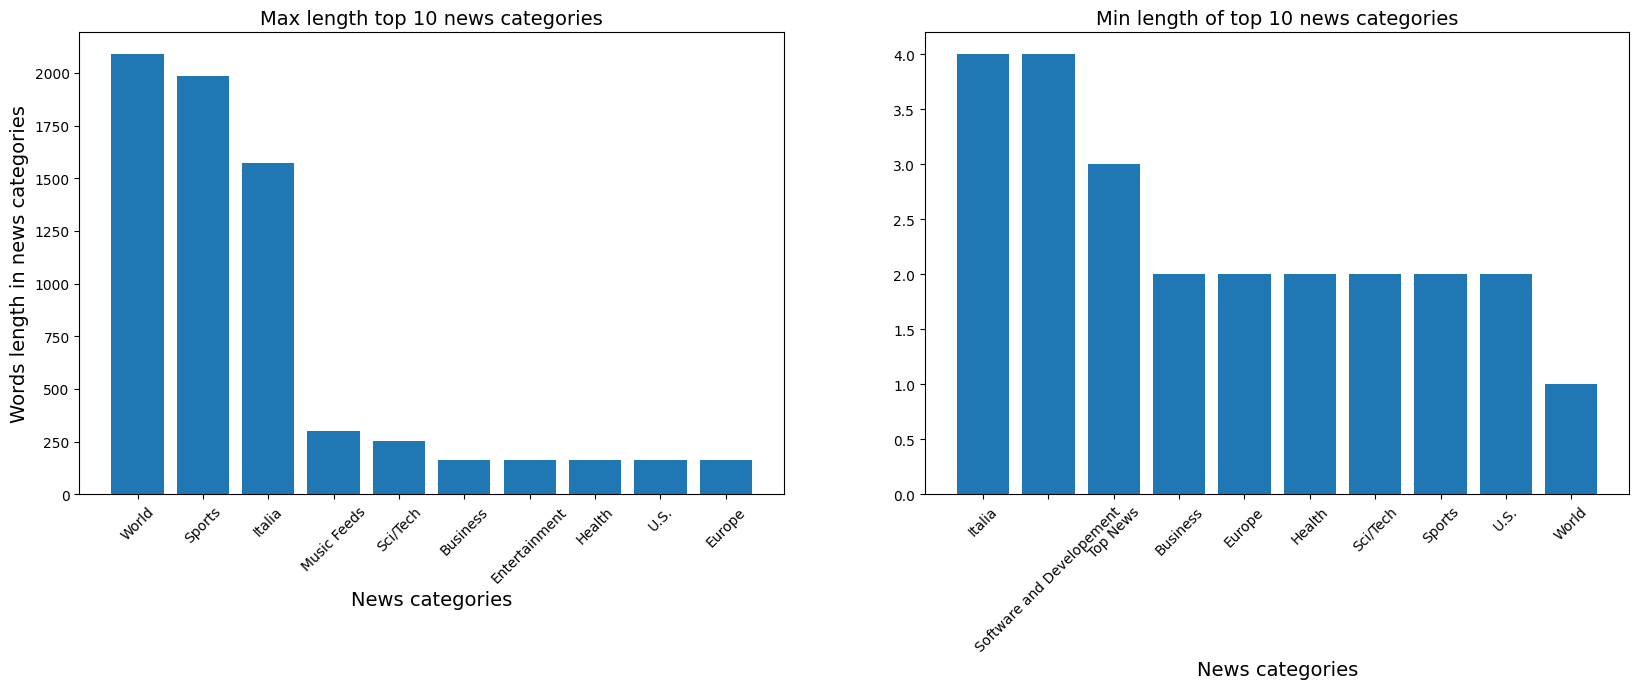

In [ ]:
min_max_len_symbols(data)

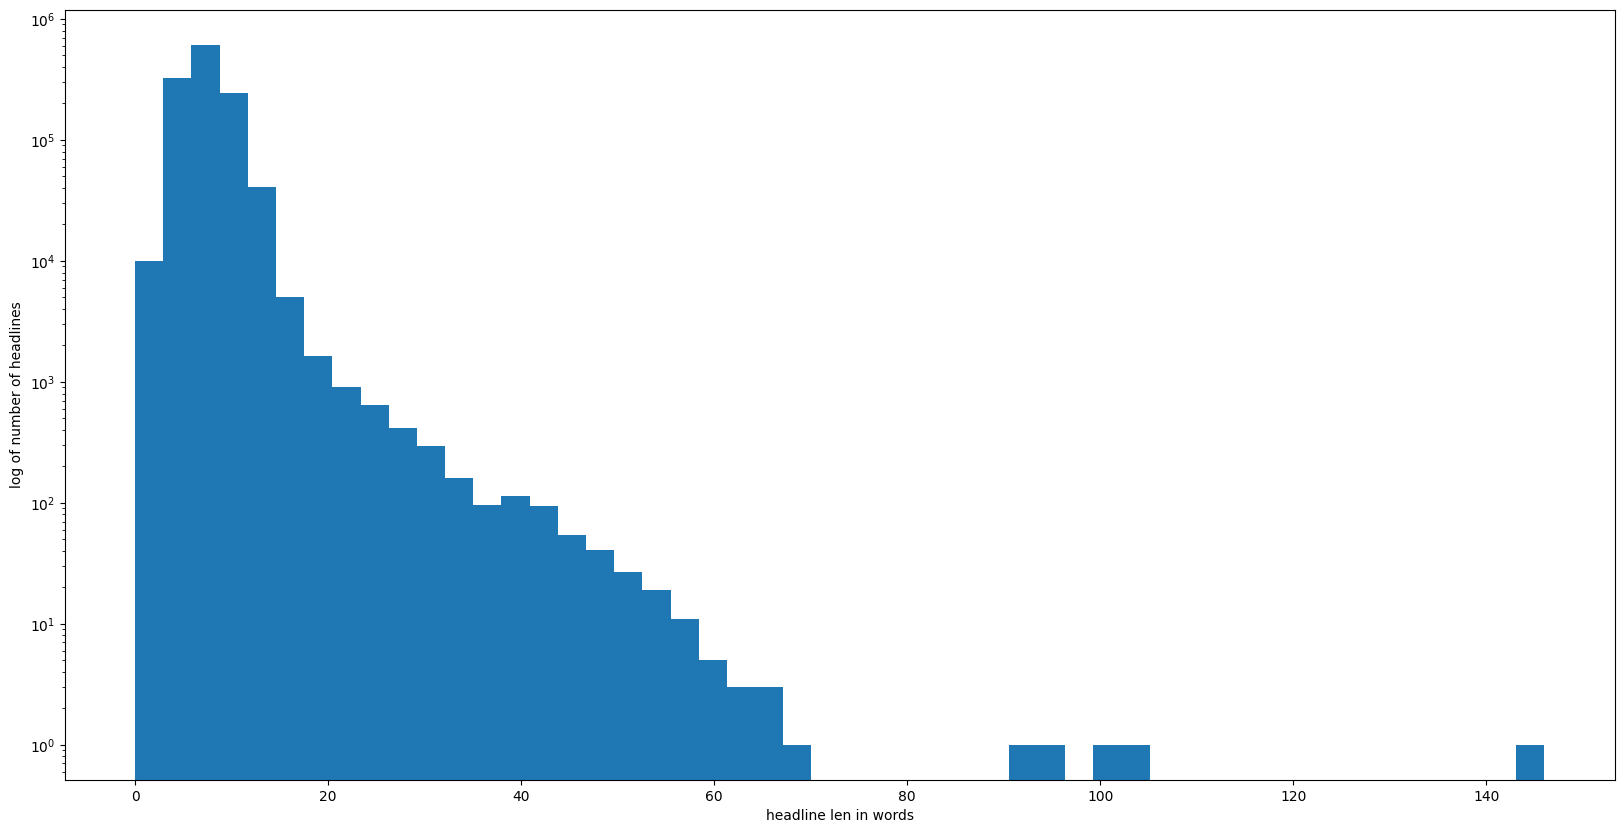

                     category  headline_len_words_max  headline_len_words_min
0                      Italia                     146                       1
1                       World                     104                       0
2                      Sports                      95                       0
3                    Sci/Tech                      47                       0
4                 Music Feeds                      45                       3
5               Entertainment                      30                       1
6                      Europe                      29                       1
7                    Top News                      29                       1
8                    Business                      27                       0
9                      Health                      25                       0
10                       U.S.                      24                       0
11  Software and Developement                      22           

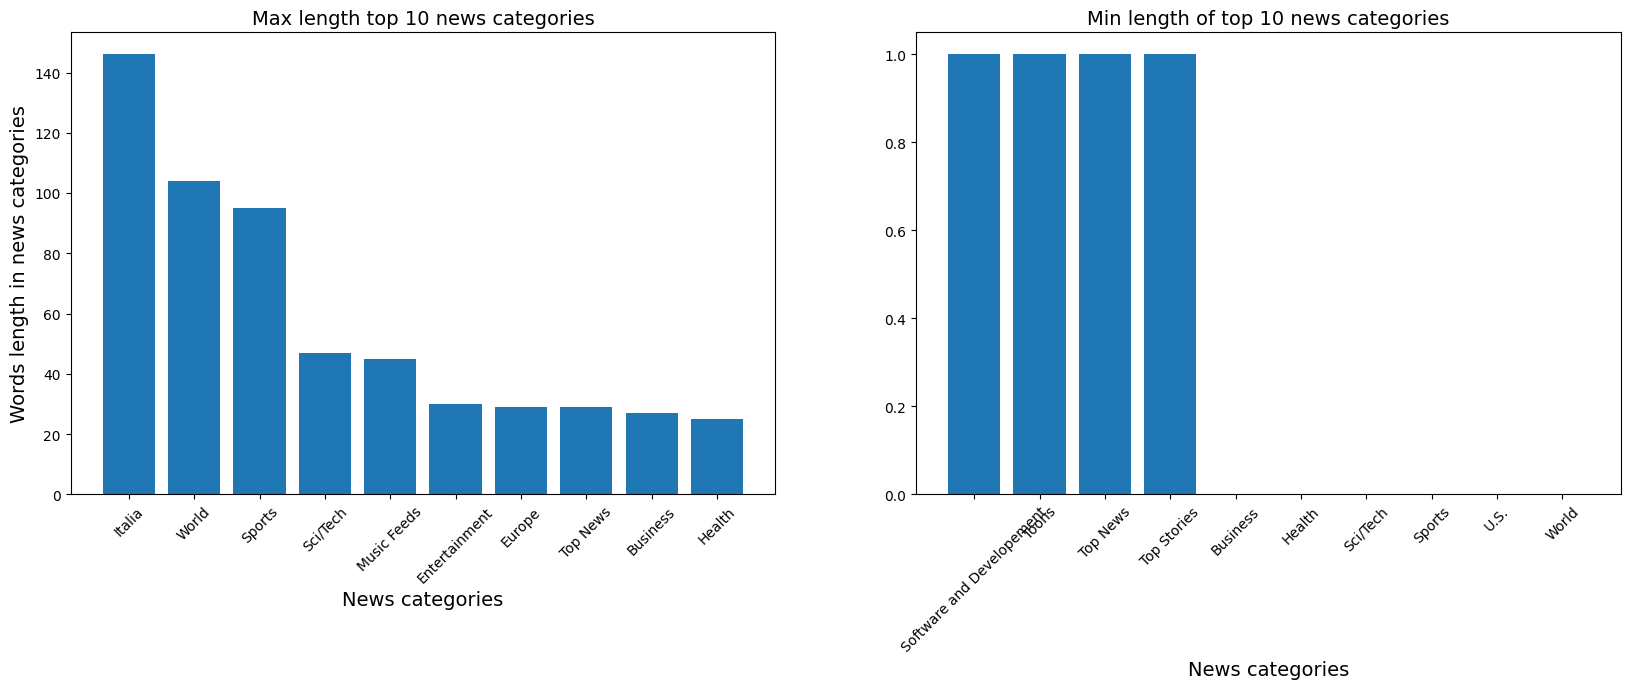

In [ ]:
min_max_len_words(data)

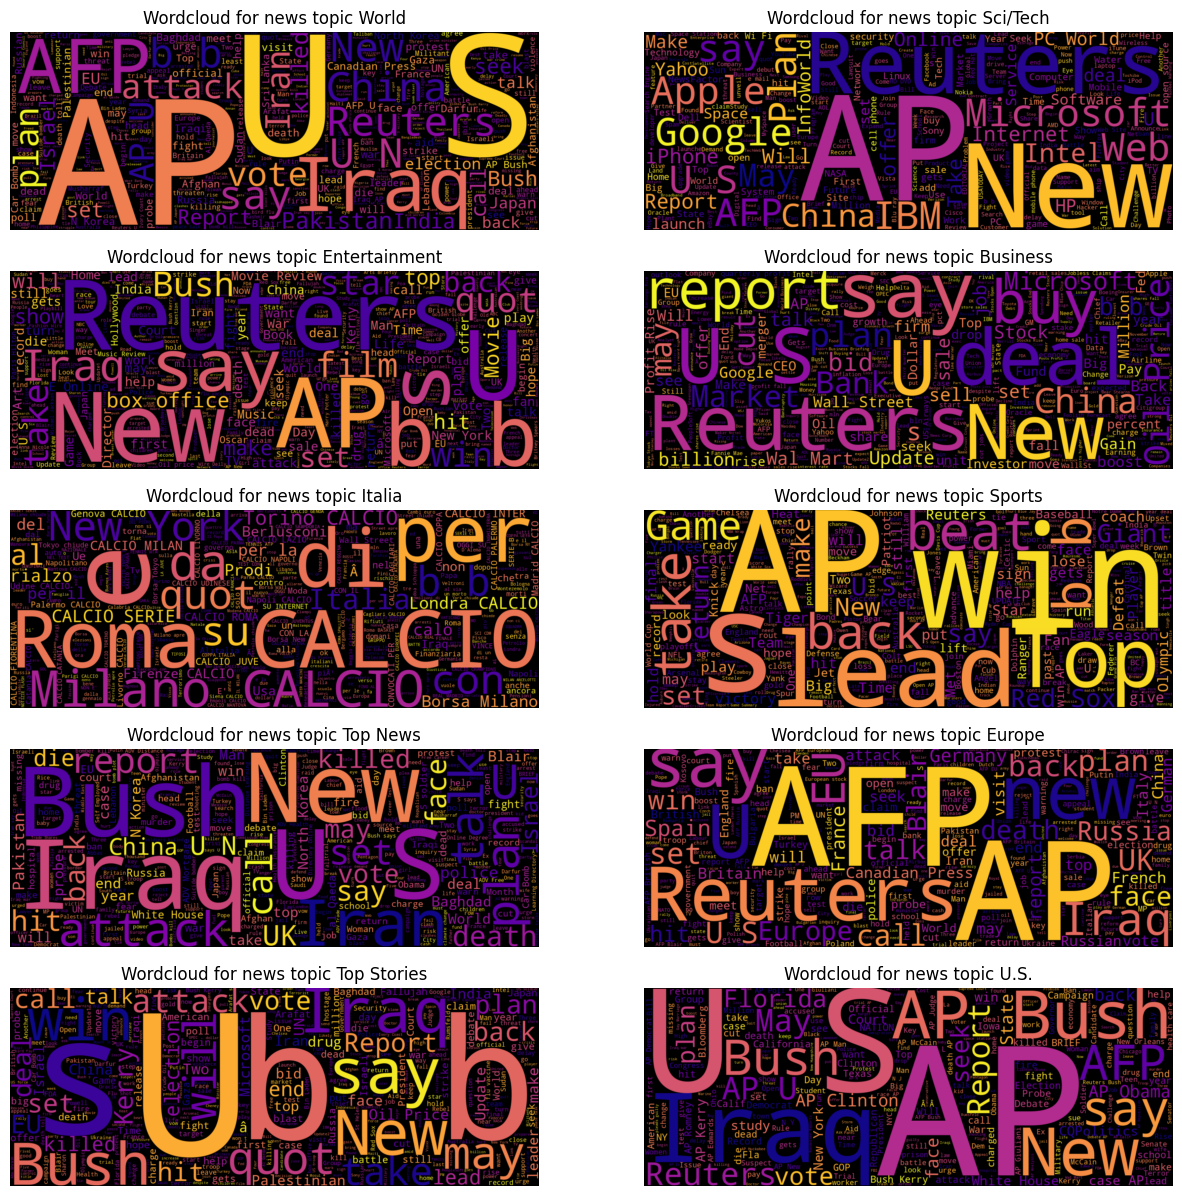

In [ ]:
word_clouds_top10(data)

# News Aggregator


https://archive.ics.uci.edu/dataset/359/news+aggregator



## data preparation

In [ ]:
!unzip 'news+aggregator.zip' -d news_aggregator

Archive:  news+aggregator.zip
  inflating: news_aggregator/2pageSessions.csv  
   creating: news_aggregator/__MACOSX/
  inflating: news_aggregator/__MACOSX/._2pageSessions.csv  
  inflating: news_aggregator/newsCorpora.csv  
  inflating: news_aggregator/__MACOSX/._newsCorpora.csv  
  inflating: news_aggregator/readme.txt  
  inflating: news_aggregator/__MACOSX/._readme.txt  


## plots